<a href="https://colab.research.google.com/github/puneetsingla17/Reinforcement-Learning-Pytorch/blob/master/Proximal_Policy_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y

# Special gym environment
!pip install gym[atari]

# For rendering environment, you can use pyvirtualdisplay.
!pip install pyvirtualdisplay
!pip install piglet

# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

# Import libraries
#
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (464 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 784 kB of 

In [ ]:
# Install spinningup on CoLab
!git clone https://github.com/openai/spinningup.git
!cd spinningup
#!pip install -e . # this will incur error: File "setup.py" not found. Directory cannot be installed in editable mode: /content
!pip install -e spinningup

Cloning into 'spinningup'...
remote: Enumerating objects: 1263, done.
remote: Total 1263 (delta 0), reused 0 (delta 0), pack-reused 1263
Receiving objects: 100% (1263/1263), 31.02 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (590/590), done.
Obtaining file:///content/spinningup
     |████████████████████████████████| 1.6MB 10.8MB/s 
     |████████████████████████████████| 13.1MB 12.8MB/s 
     |████████████████████████████████| 1.4MB 53.0MB/s 
     |████████████████████████████████| 184kB 50.1MB/s 
     |████████████████████████████████| 110.5MB 56kB/s 
     |████████████████████████████████| 734.6MB 24kB/s 
     |████████████████████████████████| 450kB 55.3MB/s 
     |████████████████████████████████| 3.8MB 46.3MB/s 
     |████████████████████████████████| 512kB 38.1MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
  Created wheel for gym: filename=gym-0.15.7-cp36-none-any.whl size=1648841 sha256=56beae06840bd076b5ad86a0e9e9b36d045513a515eb47e36cbe413d49cceb59
  Stored in

In [ ]:
# Utility functions to enable video recording of gym environment and displaying it
# To enable video, just do "env = wrap_env(env)""
# """

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

steps to follow
1> spawn out the trajectories and save them latest one upto batchsize
2 > calculate reward of trajectories
3 > calculate mean reward and std deviation and normalize the rewards
4 > multiply reward with log (p)
5 >  apply optimization


In [ ]:
#Proximal Policy optimization
import torch
import torch.nn as nn
import torch.nn.functional as f
from collections import deque
import random
import torch.optim as op

In [ ]:
import gym
env1=gym.make("BipedalWalker-v2")

In [ ]:
obsshape=env1.observation_space.shape
action=env1.action_space.n

In [ ]:
#Hyperparameters
# buffersize=100000
batchsize=64
gamma=0.99
# tau=0.99
epsilon=0.9
steps=200000
# warmupsteps=500
# eps=1
# epsend=0.01
# epsdecay=0.999

In [ ]:
class model(nn.Module):
  def __init__(self,inpdim,acdim):
    super().__init__()
    self.fc1=nn.Linear(inpdim,32)
    self.ln=nn.LayerNorm(32)
    self.fc2=nn.Linear(32,16)
    self.fc3=nn.Linear(16,acdim)
  def forward(self,x):
    out=f.leaky_relu(self.fc1(x))
    out=self.ln(out)
    out=f.leaky_relu(self.fc2(out))
    return self.fc3(out)

In [ ]:
class agent:
  def __init__(self,obsdim,naction):
    self.ag=model(obsdim,naction)
    self.na=naction
    self.optim=op.Adam(self.ag.parameters(),lr=0.0001)

  def act(self,s1):
    s1=torch.FloatTensor(s1).view(1,-1)
    actionprob=f.softmax(self.ag(s1))
    if random.random()>epsilon:
      ac=actionprob.argmax().item()
    else:
      ac=random.choice(range(self.na))
    return ac,actionprob

  def train(self,rew,logprob):
    loss=-(torch.mean(rew*logprob))
    loss.backward()
    self.optim.step()
    return loss

In [ ]:
def calc_actval(rewlist,gamma):
  rw=rewlist[::-1]
  Q=[]
  c=0
  for r in rw[1:]:
    c=r+gamma*c
    Q.append(c)
  return Q[::-1]

In [ ]:
calc_actval([1,1,1,1,1],0.88)

[3.3358719999999997, 2.6544, 1.88, 1.0]

In [ ]:
def gettrajectory_train(env,ag,batchsize):
  totalrew=[]
  totallogprob=[]
  s1=env.reset()
  for i in range(batchsize):
    s1=env.reset()
    rew=[]
    prob=[]
    logprob=[]
    done=False
    while not done:
      ac,probs=ag.act(s1)
      nextst,r,done,_=env1.step(ac)
      rew.append(r)
      probs=probs.squeeze(0)
      logprob.append(torch.log10(probs[ac]).unsqueeze(-1))
      s1=nextst
    totalrew.append(sum(rew))
    # print(torch.sum(torch.tensor(logprob)).requires_grad)   torch.tensor creates new tensor remember with bydefault requires_grad=False
    totallogprob.append(torch.sum(torch.cat(logprob)).unsqueeze(-1))
  totalrew=np.array(totalrew)
  mean=np.mean(totalrew)
  std=np.std(totalrew)
  normalizedrew=torch.tensor((totalrew-mean)/(std+0.001))

  return normalizedrew,torch.cat(totallogprob),mean

In [ ]:
ag=agent(obsshape[0],action)

In [ ]:
traj=gettrajectory_train(env1,ag,32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:
import tqdm

In [ ]:
meanrew=[]

In [ ]:
for i in tqdm.tqdm(range(1000)):
  ag.optim.zero_grad()
  rewt,probt,mean=gettrajectory_train(env1,ag,32)
  meanrew.append(mean)
  ag.train(rewt,probt)
  print(mean)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
  0%|          | 1/1000 [00:01<29:21,  1.76s/it]

-146.9966341420295


  0%|          | 2/1000 [00:03<29:40,  1.78s/it]

-169.3944440205013


  0%|          | 3/1000 [00:05<29:53,  1.80s/it]

-146.307751709843


  0%|          | 4/1000 [00:07<30:42,  1.85s/it]

-167.80715477117832


  0%|          | 5/1000 [00:09<30:20,  1.83s/it]

-175.9872945349683


  1%|          | 6/1000 [00:11<30:35,  1.85s/it]

-153.33432183162495


  1%|          | 7/1000 [00:12<30:07,  1.82s/it]

-149.75278048269521


  1%|          | 8/1000 [00:14<29:46,  1.80s/it]

-169.8839624375148


  1%|          | 9/1000 [00:16<30:01,  1.82s/it]

-166.76844564198308


  1%|          | 10/1000 [00:18<30:06,  1.82s/it]

-160.19693546886916


  1%|          | 11/1000 [00:20<30:21,  1.84s/it]

-156.70933618037697


  1%|          | 12/1000 [00:21<29:48,  1.81s/it]

-114.05762157393826


  1%|▏         | 13/1000 [00:23<29:36,  1.80s/it]

-177.4637647998094


  1%|▏         | 14/1000 [00:25<29:37,  1.80s/it]

-156.00608595672202


  2%|▏         | 15/1000 [00:27<29:45,  1.81s/it]

-142.9674942392409


  2%|▏         | 16/1000 [00:29<29:36,  1.81s/it]

-153.23410963015567


  2%|▏         | 17/1000 [00:30<29:01,  1.77s/it]

-167.70618899394242


  2%|▏         | 18/1000 [00:32<28:44,  1.76s/it]

-155.22018997459776


  2%|▏         | 19/1000 [00:34<28:58,  1.77s/it]

-179.528250475558


  2%|▏         | 20/1000 [00:35<28:21,  1.74s/it]

-124.92225835525278


  2%|▏         | 21/1000 [00:37<28:34,  1.75s/it]

-168.86977665423456


  2%|▏         | 22/1000 [00:39<28:56,  1.78s/it]

-198.79460313680232


  2%|▏         | 23/1000 [00:41<28:58,  1.78s/it]

-132.33714714815358


  2%|▏         | 24/1000 [00:43<29:04,  1.79s/it]

-153.12051966446427


  2%|▎         | 25/1000 [00:45<29:34,  1.82s/it]

-190.06959341280148


  3%|▎         | 26/1000 [00:46<29:51,  1.84s/it]

-159.532647606225


  3%|▎         | 27/1000 [00:48<29:43,  1.83s/it]

-150.11809600664688


  3%|▎         | 28/1000 [00:50<28:59,  1.79s/it]

-122.27355364046285


  3%|▎         | 29/1000 [00:52<28:51,  1.78s/it]

-172.26726332787038


  3%|▎         | 30/1000 [00:54<28:47,  1.78s/it]

-176.7029754264443


  3%|▎         | 31/1000 [00:55<28:29,  1.76s/it]

-136.43084641287487


  3%|▎         | 32/1000 [00:57<27:37,  1.71s/it]

-116.72010436339501


  3%|▎         | 33/1000 [00:59<28:06,  1.74s/it]

-145.42740989971358


  3%|▎         | 34/1000 [01:01<28:39,  1.78s/it]

-180.06684914659158


  4%|▎         | 35/1000 [01:02<29:23,  1.83s/it]

-202.2075808286715


  4%|▎         | 36/1000 [01:04<29:34,  1.84s/it]

-157.5859912467251


  4%|▎         | 37/1000 [01:06<30:23,  1.89s/it]

-194.79439228080594


  4%|▍         | 38/1000 [01:08<30:00,  1.87s/it]

-159.16061787530234


  4%|▍         | 39/1000 [01:10<29:16,  1.83s/it]

-156.74133478308013


  4%|▍         | 40/1000 [01:12<28:40,  1.79s/it]

-153.52876775547207


  4%|▍         | 41/1000 [01:13<28:20,  1.77s/it]

-161.49268821976094


  4%|▍         | 42/1000 [01:15<28:04,  1.76s/it]

-147.44096711745834


  4%|▍         | 43/1000 [01:17<28:27,  1.78s/it]

-160.8040974233281


  4%|▍         | 44/1000 [01:19<28:37,  1.80s/it]

-144.87490509327318


  4%|▍         | 45/1000 [01:21<28:36,  1.80s/it]

-148.9582286582688


  5%|▍         | 46/1000 [01:22<28:54,  1.82s/it]

-180.55321281388382


  5%|▍         | 47/1000 [01:24<28:33,  1.80s/it]

-137.51438698997828


  5%|▍         | 48/1000 [01:26<28:20,  1.79s/it]

-162.57830593403492


  5%|▍         | 49/1000 [01:28<28:04,  1.77s/it]

-140.34718407777137


  5%|▌         | 50/1000 [01:29<27:51,  1.76s/it]

-165.64792801440598


  5%|▌         | 51/1000 [01:31<27:41,  1.75s/it]

-167.30147911622493


  5%|▌         | 52/1000 [01:33<27:54,  1.77s/it]

-167.2138715505307


  5%|▌         | 53/1000 [01:35<28:13,  1.79s/it]

-154.27136085434876


  5%|▌         | 54/1000 [01:37<29:07,  1.85s/it]

-173.53796931019184


  6%|▌         | 55/1000 [01:39<28:44,  1.82s/it]

-151.89486082949148


  6%|▌         | 56/1000 [01:40<27:56,  1.78s/it]

-151.27905542414857


  6%|▌         | 57/1000 [01:42<28:18,  1.80s/it]

-132.07821585187412


  6%|▌         | 58/1000 [01:44<28:20,  1.80s/it]

-155.67805699994358


  6%|▌         | 59/1000 [01:46<28:25,  1.81s/it]

-161.69344548214025


  6%|▌         | 60/1000 [01:47<27:50,  1.78s/it]

-158.6452832886625


  6%|▌         | 61/1000 [01:49<28:13,  1.80s/it]

-156.8183561364271


  6%|▌         | 62/1000 [01:52<33:28,  2.14s/it]

-135.59546724607213


  6%|▋         | 63/1000 [01:54<31:34,  2.02s/it]

-143.03765433933452


  6%|▋         | 64/1000 [01:56<29:58,  1.92s/it]

-133.72104507816195


  6%|▋         | 65/1000 [01:57<29:13,  1.88s/it]

-165.7349381116226


  7%|▋         | 66/1000 [01:59<29:01,  1.86s/it]

-179.5390560018746


  7%|▋         | 67/1000 [02:01<28:26,  1.83s/it]

-141.61330168119673


  7%|▋         | 68/1000 [02:03<28:13,  1.82s/it]

-166.17247918657839


  7%|▋         | 69/1000 [02:04<27:52,  1.80s/it]

-137.93286603842347


  7%|▋         | 70/1000 [02:06<27:45,  1.79s/it]

-149.3993793893275


  7%|▋         | 71/1000 [02:08<28:22,  1.83s/it]

-139.94085144677126


  7%|▋         | 72/1000 [02:10<28:38,  1.85s/it]

-186.59657294429186


  7%|▋         | 73/1000 [02:12<28:35,  1.85s/it]

-167.54914193736698


  7%|▋         | 74/1000 [02:14<28:22,  1.84s/it]

-150.96478374508166


  8%|▊         | 75/1000 [02:15<27:51,  1.81s/it]

-178.9797502126387


  8%|▊         | 76/1000 [02:17<27:27,  1.78s/it]

-146.56023165832553


  8%|▊         | 77/1000 [02:19<27:32,  1.79s/it]

-144.0746597198867


  8%|▊         | 78/1000 [02:21<28:02,  1.82s/it]

-175.01101310208475


  8%|▊         | 79/1000 [02:23<27:59,  1.82s/it]

-173.3528172014902


  8%|▊         | 80/1000 [02:25<28:05,  1.83s/it]

-148.9621238818063


  8%|▊         | 81/1000 [02:26<27:48,  1.82s/it]

-150.82846434671245


  8%|▊         | 82/1000 [02:28<28:28,  1.86s/it]

-189.0074862539709


  8%|▊         | 83/1000 [02:30<28:10,  1.84s/it]

-169.83884405935268


  8%|▊         | 84/1000 [02:32<28:13,  1.85s/it]

-155.2768874228296


  8%|▊         | 85/1000 [02:34<28:19,  1.86s/it]

-176.47798358759366


  9%|▊         | 86/1000 [02:36<27:44,  1.82s/it]

-142.6749109552833


  9%|▊         | 87/1000 [02:37<27:49,  1.83s/it]

-143.37705468978882


  9%|▉         | 88/1000 [02:39<27:15,  1.79s/it]

-125.80418855796746


  9%|▉         | 89/1000 [02:41<27:38,  1.82s/it]

-196.19160049348378


  9%|▉         | 90/1000 [02:43<27:34,  1.82s/it]

-144.29333736568233


  9%|▉         | 91/1000 [02:45<27:33,  1.82s/it]

-166.7054725313118


  9%|▉         | 92/1000 [02:46<27:28,  1.82s/it]

-133.51832493883404


  9%|▉         | 93/1000 [02:48<27:26,  1.82s/it]

-160.70499650649617


  9%|▉         | 94/1000 [02:50<27:19,  1.81s/it]

-193.13276349961114


 10%|▉         | 95/1000 [02:52<26:52,  1.78s/it]

-166.0398706284509


 10%|▉         | 96/1000 [02:54<26:46,  1.78s/it]

-145.0778883321106


 10%|▉         | 97/1000 [02:55<26:50,  1.78s/it]

-159.35701280019302


 10%|▉         | 98/1000 [02:57<27:38,  1.84s/it]

-159.4074338461126


 10%|▉         | 99/1000 [02:59<27:38,  1.84s/it]

-195.84825985186941


 10%|█         | 100/1000 [03:01<28:01,  1.87s/it]

-162.5633304056196


 10%|█         | 101/1000 [03:03<27:54,  1.86s/it]

-177.74191257810685


 10%|█         | 102/1000 [03:05<27:19,  1.83s/it]

-145.2446514532806


 10%|█         | 103/1000 [03:06<26:53,  1.80s/it]

-133.3574303817541


 10%|█         | 104/1000 [03:08<27:04,  1.81s/it]

-140.50543372225644


 10%|█         | 105/1000 [03:10<26:37,  1.79s/it]

-149.05916235076282


 11%|█         | 106/1000 [03:12<26:44,  1.79s/it]

-167.56329807321242


 11%|█         | 107/1000 [03:14<26:55,  1.81s/it]

-174.5401407003229


 11%|█         | 108/1000 [03:16<27:03,  1.82s/it]

-153.08158407727564


 11%|█         | 109/1000 [03:17<27:15,  1.84s/it]

-143.12375078495936


 11%|█         | 110/1000 [03:19<26:57,  1.82s/it]

-126.65612689140782


 11%|█         | 111/1000 [03:21<27:13,  1.84s/it]

-160.61394708550904


 11%|█         | 112/1000 [03:23<27:10,  1.84s/it]

-177.29433539077334


 11%|█▏        | 113/1000 [03:25<26:59,  1.83s/it]

-174.6093560845368


 11%|█▏        | 114/1000 [03:27<27:34,  1.87s/it]

-163.9526710705835


 12%|█▏        | 115/1000 [03:29<27:42,  1.88s/it]

-152.61654479606423


 12%|█▏        | 116/1000 [03:30<27:37,  1.87s/it]

-181.11486439245624


 12%|█▏        | 117/1000 [03:32<27:54,  1.90s/it]

-170.91193526005588


 12%|█▏        | 118/1000 [03:34<27:36,  1.88s/it]

-165.4477973083493


 12%|█▏        | 119/1000 [03:36<27:37,  1.88s/it]

-184.63878914345207


 12%|█▏        | 120/1000 [03:38<27:17,  1.86s/it]

-137.03347461107592


 12%|█▏        | 121/1000 [03:40<27:19,  1.87s/it]

-162.56448676787733


 12%|█▏        | 122/1000 [03:42<27:03,  1.85s/it]

-150.3848947588735


 12%|█▏        | 123/1000 [03:43<27:06,  1.85s/it]

-173.8734152798582


 12%|█▏        | 124/1000 [03:45<26:44,  1.83s/it]

-144.58981347710318


 12%|█▎        | 125/1000 [03:47<26:36,  1.82s/it]

-163.70710677354566


 13%|█▎        | 126/1000 [03:49<26:12,  1.80s/it]

-179.66128103210175


 13%|█▎        | 127/1000 [03:51<25:51,  1.78s/it]

-134.80852666230228


 13%|█▎        | 128/1000 [03:52<25:32,  1.76s/it]

-135.80565860395947


 13%|█▎        | 129/1000 [03:54<26:11,  1.80s/it]

-147.84598674971733


 13%|█▎        | 130/1000 [03:56<25:25,  1.75s/it]

-126.97092278937237


 13%|█▎        | 131/1000 [03:59<32:35,  2.25s/it]

-138.5588816713461


 13%|█▎        | 132/1000 [04:01<30:31,  2.11s/it]

-141.46011851427176


 13%|█▎        | 133/1000 [04:03<29:14,  2.02s/it]

-149.393899025564


 13%|█▎        | 134/1000 [04:05<28:14,  1.96s/it]

-143.54061039842094


 14%|█▎        | 135/1000 [04:06<27:40,  1.92s/it]

-167.42777139613418


 14%|█▎        | 136/1000 [04:08<27:33,  1.91s/it]

-178.40635165898738


 14%|█▎        | 137/1000 [04:10<27:04,  1.88s/it]

-165.7158185097856


 14%|█▍        | 138/1000 [04:12<26:32,  1.85s/it]

-149.49291156177088


 14%|█▍        | 139/1000 [04:14<26:19,  1.83s/it]

-159.9733710238026


 14%|█▍        | 140/1000 [04:15<25:34,  1.78s/it]

-154.24107802762535


 14%|█▍        | 141/1000 [04:17<25:21,  1.77s/it]

-134.0587862959221


 14%|█▍        | 142/1000 [04:19<25:36,  1.79s/it]

-159.95905395264754


 14%|█▍        | 143/1000 [04:21<25:58,  1.82s/it]

-148.1595891812209


 14%|█▍        | 144/1000 [04:23<26:05,  1.83s/it]

-145.1952528579179


 14%|█▍        | 145/1000 [04:25<26:35,  1.87s/it]

-194.42635623023608


 15%|█▍        | 146/1000 [04:26<25:52,  1.82s/it]

-147.85396102552073


 15%|█▍        | 147/1000 [04:28<25:57,  1.83s/it]

-134.47207806951064


 15%|█▍        | 148/1000 [04:30<25:26,  1.79s/it]

-162.60252168703548


 15%|█▍        | 149/1000 [04:32<25:44,  1.82s/it]

-176.34585554407798


 15%|█▌        | 150/1000 [04:34<25:47,  1.82s/it]

-176.76172932866922


 15%|█▌        | 151/1000 [04:35<25:47,  1.82s/it]

-165.6098494414086


 15%|█▌        | 152/1000 [04:37<25:33,  1.81s/it]

-152.90469865346688


 15%|█▌        | 153/1000 [04:39<25:24,  1.80s/it]

-118.92959683576109


 15%|█▌        | 154/1000 [04:41<25:02,  1.78s/it]

-138.43963929108082


 16%|█▌        | 155/1000 [04:43<25:13,  1.79s/it]

-160.95200551228447


 16%|█▌        | 156/1000 [04:44<25:15,  1.80s/it]

-159.1095107600484


 16%|█▌        | 157/1000 [04:46<25:33,  1.82s/it]

-154.72084694972898


 16%|█▌        | 158/1000 [04:48<24:33,  1.75s/it]

-153.61275798560686


 16%|█▌        | 159/1000 [04:50<24:53,  1.78s/it]

-152.88779322285137


 16%|█▌        | 160/1000 [04:51<25:11,  1.80s/it]

-182.70526285714678


 16%|█▌        | 161/1000 [04:53<24:48,  1.77s/it]

-158.2452059101975


 16%|█▌        | 162/1000 [04:55<24:51,  1.78s/it]

-122.3443078450114


 16%|█▋        | 163/1000 [04:57<25:22,  1.82s/it]

-162.13617484449534


 16%|█▋        | 164/1000 [04:59<25:48,  1.85s/it]

-157.39678015367454


 16%|█▋        | 165/1000 [05:01<25:14,  1.81s/it]

-170.90863551016054


 17%|█▋        | 166/1000 [05:02<25:08,  1.81s/it]

-151.9836807653055


 17%|█▋        | 167/1000 [05:04<25:19,  1.82s/it]

-166.4447379316463


 17%|█▋        | 168/1000 [05:08<32:17,  2.33s/it]

-143.17378499821558


 17%|█▋        | 169/1000 [05:11<36:16,  2.62s/it]

-147.42824137514214


 17%|█▋        | 170/1000 [05:13<32:28,  2.35s/it]

-167.5631667444571


 17%|█▋        | 171/1000 [05:14<29:53,  2.16s/it]

-156.4812736996031


 17%|█▋        | 172/1000 [05:16<28:27,  2.06s/it]

-149.00461318753662


 17%|█▋        | 173/1000 [05:18<26:55,  1.95s/it]

-155.2445867147474


 17%|█▋        | 174/1000 [05:20<26:00,  1.89s/it]

-157.02550370792795


 18%|█▊        | 175/1000 [05:21<25:22,  1.84s/it]

-148.8234381701709


 18%|█▊        | 176/1000 [05:23<24:49,  1.81s/it]

-152.1508738299894


 18%|█▊        | 177/1000 [05:25<25:02,  1.83s/it]

-174.6166920371943


 18%|█▊        | 178/1000 [05:27<24:32,  1.79s/it]

-156.7377161871653


 18%|█▊        | 179/1000 [05:29<25:08,  1.84s/it]

-136.01851643490008


 18%|█▊        | 180/1000 [05:30<24:29,  1.79s/it]

-145.37387629826114


 18%|█▊        | 181/1000 [05:32<24:57,  1.83s/it]

-149.10492980155453


 18%|█▊        | 182/1000 [05:34<24:42,  1.81s/it]

-148.60859128674497


 18%|█▊        | 183/1000 [05:36<24:22,  1.79s/it]

-154.5891505955869


 18%|█▊        | 184/1000 [05:38<24:34,  1.81s/it]

-157.10874405518913


 18%|█▊        | 185/1000 [05:40<24:39,  1.82s/it]

-172.34093871614397


 19%|█▊        | 186/1000 [05:41<24:38,  1.82s/it]

-165.66805797453276


 19%|█▊        | 187/1000 [05:43<24:33,  1.81s/it]

-174.2281144086665


 19%|█▉        | 188/1000 [05:45<24:59,  1.85s/it]

-156.35259599957388


 19%|█▉        | 189/1000 [05:47<24:33,  1.82s/it]

-137.87876639582737


 19%|█▉        | 190/1000 [05:49<24:12,  1.79s/it]

-155.0231036320659


 19%|█▉        | 191/1000 [05:50<24:23,  1.81s/it]

-164.25276702622693


 19%|█▉        | 192/1000 [05:52<24:46,  1.84s/it]

-163.14888766514275


 19%|█▉        | 193/1000 [05:54<24:05,  1.79s/it]

-129.1010347150988


 19%|█▉        | 194/1000 [05:56<23:45,  1.77s/it]

-142.2347542674575


 20%|█▉        | 195/1000 [05:57<23:38,  1.76s/it]

-163.6269184414507


 20%|█▉        | 196/1000 [05:59<23:21,  1.74s/it]

-133.23647317493734


 20%|█▉        | 197/1000 [06:01<23:28,  1.75s/it]

-153.32694637148396


 20%|█▉        | 198/1000 [06:03<23:28,  1.76s/it]

-159.47764343752928


 20%|█▉        | 199/1000 [06:06<28:03,  2.10s/it]

-151.13769608997984


 20%|██        | 200/1000 [06:09<33:42,  2.53s/it]

-161.836982826952


 20%|██        | 201/1000 [06:11<30:44,  2.31s/it]

-152.90481324274657


 20%|██        | 202/1000 [06:13<28:37,  2.15s/it]

-149.90518386557076


 20%|██        | 203/1000 [06:14<26:56,  2.03s/it]

-149.8060794021443


 20%|██        | 204/1000 [06:16<26:18,  1.98s/it]

-161.98942540870632


 20%|██        | 205/1000 [06:18<26:07,  1.97s/it]

-177.6651236164647


 21%|██        | 206/1000 [06:20<25:17,  1.91s/it]

-135.42933305529024


 21%|██        | 207/1000 [06:22<24:27,  1.85s/it]

-144.55562484421762


 21%|██        | 208/1000 [06:23<23:49,  1.80s/it]

-154.0793905089022


 21%|██        | 209/1000 [06:25<23:45,  1.80s/it]

-150.95539091586244


 21%|██        | 210/1000 [06:27<23:16,  1.77s/it]

-137.63070979526017


 21%|██        | 211/1000 [06:29<23:37,  1.80s/it]

-147.20612496733017


 21%|██        | 212/1000 [06:31<23:23,  1.78s/it]

-153.7508395317284


 21%|██▏       | 213/1000 [06:32<23:32,  1.80s/it]

-153.5206109638089


 21%|██▏       | 214/1000 [06:34<23:31,  1.80s/it]

-165.35844455375843


 22%|██▏       | 215/1000 [06:36<23:41,  1.81s/it]

-116.220734756718


 22%|██▏       | 216/1000 [06:38<24:01,  1.84s/it]

-157.97873984799745


 22%|██▏       | 217/1000 [06:40<23:43,  1.82s/it]

-124.81519160085571


 22%|██▏       | 218/1000 [06:42<23:52,  1.83s/it]

-168.30124249060628


 22%|██▏       | 219/1000 [06:43<23:00,  1.77s/it]

-127.53496721499286


 22%|██▏       | 220/1000 [06:45<22:49,  1.76s/it]

-153.20974676417214


 22%|██▏       | 221/1000 [06:47<22:48,  1.76s/it]

-153.83065377882815


 22%|██▏       | 222/1000 [06:48<22:41,  1.75s/it]

-155.19896965346862


 22%|██▏       | 223/1000 [06:50<22:41,  1.75s/it]

-136.69314001285866


 22%|██▏       | 224/1000 [06:52<22:50,  1.77s/it]

-169.07232910861356


 22%|██▎       | 225/1000 [06:54<22:48,  1.77s/it]

-157.41711820652932


 23%|██▎       | 226/1000 [06:57<28:12,  2.19s/it]

-137.428781071292


 23%|██▎       | 227/1000 [06:59<26:37,  2.07s/it]

-152.7134018898556


 23%|██▎       | 228/1000 [07:00<25:18,  1.97s/it]

-148.31157715549543


 23%|██▎       | 229/1000 [07:02<24:45,  1.93s/it]

-150.77707353652886


 23%|██▎       | 230/1000 [07:04<24:01,  1.87s/it]

-138.3153179739943


 23%|██▎       | 231/1000 [07:06<23:24,  1.83s/it]

-118.9120346230229


 23%|██▎       | 232/1000 [07:07<22:55,  1.79s/it]

-153.09294028672363


 23%|██▎       | 233/1000 [07:09<22:45,  1.78s/it]

-148.3805556799618


 23%|██▎       | 234/1000 [07:11<22:20,  1.75s/it]

-146.33539626372294


 24%|██▎       | 235/1000 [07:13<22:36,  1.77s/it]

-161.3088187824913


 24%|██▎       | 236/1000 [07:15<22:57,  1.80s/it]

-172.74762018666326


 24%|██▎       | 237/1000 [07:16<22:57,  1.80s/it]

-151.25774359169645


 24%|██▍       | 238/1000 [07:18<23:12,  1.83s/it]

-154.42826655112964


 24%|██▍       | 239/1000 [07:20<23:09,  1.83s/it]

-154.05057565085636


 24%|██▍       | 240/1000 [07:22<23:08,  1.83s/it]

-151.166161168918


 24%|██▍       | 241/1000 [07:24<23:15,  1.84s/it]

-155.61992414768244


 24%|██▍       | 242/1000 [07:26<23:02,  1.82s/it]

-153.87695070796923


 24%|██▍       | 243/1000 [07:27<22:45,  1.80s/it]

-146.086390266095


 24%|██▍       | 244/1000 [07:29<22:14,  1.77s/it]

-138.56772748822863


 24%|██▍       | 245/1000 [07:31<22:24,  1.78s/it]

-163.55999106377016


 25%|██▍       | 246/1000 [07:32<22:02,  1.75s/it]

-150.39252856247865


 25%|██▍       | 247/1000 [07:34<22:09,  1.77s/it]

-175.5370541791434


 25%|██▍       | 248/1000 [07:36<22:11,  1.77s/it]

-146.5485341583566


 25%|██▍       | 249/1000 [07:38<22:03,  1.76s/it]

-158.93517915089456


 25%|██▌       | 250/1000 [07:40<22:34,  1.81s/it]

-174.43377001458254


 25%|██▌       | 251/1000 [07:42<22:38,  1.81s/it]

-166.66270922454578


 25%|██▌       | 252/1000 [07:43<22:24,  1.80s/it]

-133.6376461019575


 25%|██▌       | 253/1000 [07:45<22:41,  1.82s/it]

-121.10627913063011


 25%|██▌       | 254/1000 [07:47<22:40,  1.82s/it]

-156.758249319836


 26%|██▌       | 255/1000 [07:49<22:36,  1.82s/it]

-130.58279302329362


 26%|██▌       | 256/1000 [07:51<22:25,  1.81s/it]

-161.44481767680304


 26%|██▌       | 257/1000 [07:52<21:59,  1.78s/it]

-138.0161708824659


 26%|██▌       | 258/1000 [07:54<22:42,  1.84s/it]

-148.44528508109113


 26%|██▌       | 259/1000 [07:56<22:29,  1.82s/it]

-174.89668057586942


 26%|██▌       | 260/1000 [07:58<22:03,  1.79s/it]

-154.55075554837978


 26%|██▌       | 261/1000 [08:00<22:15,  1.81s/it]

-156.9341243032022


 26%|██▌       | 262/1000 [08:01<22:23,  1.82s/it]

-177.2590490736231


 26%|██▋       | 263/1000 [08:03<22:06,  1.80s/it]

-157.6564151918291


 26%|██▋       | 264/1000 [08:05<22:13,  1.81s/it]

-146.6377449006476


 26%|██▋       | 265/1000 [08:07<22:14,  1.82s/it]

-148.21986424477703


 27%|██▋       | 266/1000 [08:09<22:27,  1.84s/it]

-196.71030795912768


 27%|██▋       | 267/1000 [08:10<22:00,  1.80s/it]

-166.11708637464739


 27%|██▋       | 268/1000 [08:12<21:47,  1.79s/it]

-153.6480800715726


 27%|██▋       | 269/1000 [08:15<26:54,  2.21s/it]

-138.22250335683464


 27%|██▋       | 270/1000 [08:17<25:38,  2.11s/it]

-148.04961524951187


 27%|██▋       | 271/1000 [08:19<24:39,  2.03s/it]

-161.56781845490215


 27%|██▋       | 272/1000 [08:21<23:32,  1.94s/it]

-148.6166149591574


 27%|██▋       | 273/1000 [08:23<23:22,  1.93s/it]

-176.53753266253915


 27%|██▋       | 274/1000 [08:25<23:30,  1.94s/it]

-175.75229913397112


 28%|██▊       | 275/1000 [08:26<22:37,  1.87s/it]

-134.30482641705396


 28%|██▊       | 276/1000 [08:28<22:00,  1.82s/it]

-151.11945175197067


 28%|██▊       | 277/1000 [08:30<21:57,  1.82s/it]

-172.46258614677964


 28%|██▊       | 278/1000 [08:32<21:44,  1.81s/it]

-142.45272567787427


 28%|██▊       | 279/1000 [08:33<21:09,  1.76s/it]

-143.3538232112448


 28%|██▊       | 280/1000 [08:35<21:25,  1.79s/it]

-168.4964745685232


 28%|██▊       | 281/1000 [08:37<21:13,  1.77s/it]

-134.6692401246276


 28%|██▊       | 282/1000 [08:39<21:46,  1.82s/it]

-170.8902568462181


 28%|██▊       | 283/1000 [08:41<21:23,  1.79s/it]

-145.07941543258386


 28%|██▊       | 284/1000 [08:43<22:01,  1.85s/it]

-159.24334887959424


 28%|██▊       | 285/1000 [08:44<21:35,  1.81s/it]

-126.46561839743038


 29%|██▊       | 286/1000 [08:48<27:47,  2.34s/it]

-153.96300529632737


 29%|██▊       | 287/1000 [08:50<25:41,  2.16s/it]

-139.53189342667548


 29%|██▉       | 288/1000 [08:52<24:44,  2.09s/it]

-170.48505300225077


 29%|██▉       | 289/1000 [08:53<23:13,  1.96s/it]

-121.89596379557099


 29%|██▉       | 290/1000 [08:55<22:28,  1.90s/it]

-142.33561513325387


 29%|██▉       | 291/1000 [08:57<21:59,  1.86s/it]

-169.26664887672058


 29%|██▉       | 292/1000 [08:58<21:25,  1.82s/it]

-145.67783527777405


 29%|██▉       | 293/1000 [09:00<21:00,  1.78s/it]

-127.97718862585748


 29%|██▉       | 294/1000 [09:02<20:54,  1.78s/it]

-119.7461463395009


 30%|██▉       | 295/1000 [09:04<21:43,  1.85s/it]

-163.7734719204112


 30%|██▉       | 296/1000 [09:07<26:13,  2.24s/it]

-113.70457653202249


 30%|██▉       | 297/1000 [09:09<24:51,  2.12s/it]

-168.33828086587852


 30%|██▉       | 298/1000 [09:11<23:01,  1.97s/it]

-126.43360925666315


 30%|██▉       | 299/1000 [09:12<22:43,  1.94s/it]

-163.60281694665383


 30%|███       | 300/1000 [09:14<22:15,  1.91s/it]

-156.20854739443988


 30%|███       | 301/1000 [09:16<21:48,  1.87s/it]

-161.91981519817938


 30%|███       | 302/1000 [09:18<21:48,  1.87s/it]

-176.58706662214473


 30%|███       | 303/1000 [09:20<21:24,  1.84s/it]

-131.62550809354784


 30%|███       | 304/1000 [09:22<21:08,  1.82s/it]

-131.70186552493868


 30%|███       | 305/1000 [09:23<21:05,  1.82s/it]

-158.65373606373484


 31%|███       | 306/1000 [09:25<21:58,  1.90s/it]

-168.52339114538148


 31%|███       | 307/1000 [09:27<21:36,  1.87s/it]

-141.22027647470452


 31%|███       | 308/1000 [09:29<21:00,  1.82s/it]

-154.36934704083723


 31%|███       | 309/1000 [09:31<20:54,  1.82s/it]

-155.91958445487842


 31%|███       | 310/1000 [09:33<21:17,  1.85s/it]

-128.48320083913


 31%|███       | 311/1000 [09:34<21:07,  1.84s/it]

-151.72006931927842


 31%|███       | 312/1000 [09:36<20:34,  1.79s/it]

-126.72774442356673


 31%|███▏      | 313/1000 [09:38<20:50,  1.82s/it]

-154.79823220266815


 31%|███▏      | 314/1000 [09:40<20:52,  1.83s/it]

-140.58933316962356


 32%|███▏      | 315/1000 [09:42<20:27,  1.79s/it]

-176.32367674649544


 32%|███▏      | 316/1000 [09:43<20:34,  1.80s/it]

-175.17793098590903


 32%|███▏      | 317/1000 [09:45<20:29,  1.80s/it]

-124.34535437698541


 32%|███▏      | 318/1000 [09:47<20:25,  1.80s/it]

-152.48172804520448


 32%|███▏      | 319/1000 [09:49<20:52,  1.84s/it]

-159.71927569369427


 32%|███▏      | 320/1000 [09:51<20:41,  1.83s/it]

-137.7703285797184


 32%|███▏      | 321/1000 [09:53<20:35,  1.82s/it]

-174.16201863504028


 32%|███▏      | 322/1000 [09:54<19:47,  1.75s/it]

-143.69377865221256


 32%|███▏      | 323/1000 [09:56<20:27,  1.81s/it]

-189.43155152389886


 32%|███▏      | 324/1000 [09:58<19:58,  1.77s/it]

-126.74884552977421


 32%|███▎      | 325/1000 [10:00<19:50,  1.76s/it]

-141.97080770327443


 33%|███▎      | 326/1000 [10:01<20:32,  1.83s/it]

-157.56192427735562


 33%|███▎      | 327/1000 [10:03<20:41,  1.85s/it]

-136.594340291744


 33%|███▎      | 328/1000 [10:05<20:36,  1.84s/it]

-167.85533886328454


 33%|███▎      | 329/1000 [10:07<20:40,  1.85s/it]

-145.60649601827583


 33%|███▎      | 330/1000 [10:09<20:19,  1.82s/it]

-136.05899737330637


 33%|███▎      | 331/1000 [10:11<20:39,  1.85s/it]

-166.0652754824145


 33%|███▎      | 332/1000 [10:13<20:49,  1.87s/it]

-150.89017802303385


 33%|███▎      | 333/1000 [10:14<20:23,  1.83s/it]

-133.967903712058


 33%|███▎      | 334/1000 [10:16<20:27,  1.84s/it]

-145.55343197372608


 34%|███▎      | 335/1000 [10:18<20:28,  1.85s/it]

-156.5103107519709


 34%|███▎      | 336/1000 [10:20<20:16,  1.83s/it]

-142.07440813888923


 34%|███▎      | 337/1000 [10:22<20:08,  1.82s/it]

-117.98674134672635


 34%|███▍      | 338/1000 [10:24<20:04,  1.82s/it]

-129.79993132541654


 34%|███▍      | 339/1000 [10:25<19:55,  1.81s/it]

-129.27149977459482


 34%|███▍      | 340/1000 [10:27<20:20,  1.85s/it]

-156.39492102057545


 34%|███▍      | 341/1000 [10:29<20:18,  1.85s/it]

-153.9184394103331


 34%|███▍      | 342/1000 [10:31<19:37,  1.79s/it]

-127.13295345105118


 34%|███▍      | 343/1000 [10:33<19:33,  1.79s/it]

-174.7995345188762


 34%|███▍      | 344/1000 [10:34<19:43,  1.80s/it]

-125.1405641768608


 34%|███▍      | 345/1000 [10:36<19:45,  1.81s/it]

-161.15679442354912


 35%|███▍      | 346/1000 [10:38<19:22,  1.78s/it]

-119.9142285797854


 35%|███▍      | 347/1000 [10:40<19:36,  1.80s/it]

-141.7370757353273


 35%|███▍      | 348/1000 [10:42<19:50,  1.83s/it]

-178.79741765645372


 35%|███▍      | 349/1000 [10:43<19:30,  1.80s/it]

-149.07200254420925


 35%|███▌      | 350/1000 [10:45<19:44,  1.82s/it]

-177.33272611932728


 35%|███▌      | 351/1000 [10:47<19:39,  1.82s/it]

-149.02690391688532


 35%|███▌      | 352/1000 [10:49<19:40,  1.82s/it]

-148.41000527789782


 35%|███▌      | 353/1000 [10:51<19:37,  1.82s/it]

-151.77635795347265


 35%|███▌      | 354/1000 [10:53<19:55,  1.85s/it]

-174.1964572195481


 36%|███▌      | 355/1000 [10:55<20:08,  1.87s/it]

-149.23568797384087


 36%|███▌      | 356/1000 [10:56<20:07,  1.88s/it]

-155.79399628132805


 36%|███▌      | 357/1000 [10:58<19:48,  1.85s/it]

-150.34704786253005


 36%|███▌      | 358/1000 [11:00<19:18,  1.80s/it]

-128.86222778976304


 36%|███▌      | 359/1000 [11:02<19:12,  1.80s/it]

-180.62867778616874


 36%|███▌      | 360/1000 [11:04<19:06,  1.79s/it]

-127.57609682345756


 36%|███▌      | 361/1000 [11:05<19:08,  1.80s/it]

-160.98574742732745


 36%|███▌      | 362/1000 [11:07<19:14,  1.81s/it]

-135.64778347420517


 36%|███▋      | 363/1000 [11:09<19:20,  1.82s/it]

-146.14492934677315


 36%|███▋      | 364/1000 [11:11<19:28,  1.84s/it]

-171.60794865196624


 36%|███▋      | 365/1000 [11:14<24:50,  2.35s/it]

-138.5538794662318


 37%|███▋      | 366/1000 [11:16<23:07,  2.19s/it]

-162.1763113284182


 37%|███▋      | 367/1000 [11:18<21:30,  2.04s/it]

-128.54563028315138


 37%|███▋      | 368/1000 [11:20<20:52,  1.98s/it]

-136.95178209307682


 37%|███▋      | 369/1000 [11:22<20:17,  1.93s/it]

-148.443675298686


 37%|███▋      | 370/1000 [11:23<20:04,  1.91s/it]

-154.1140597140286


 37%|███▋      | 371/1000 [11:25<19:56,  1.90s/it]

-154.69498800016407


 37%|███▋      | 372/1000 [11:27<19:26,  1.86s/it]

-149.53212739597726


 37%|███▋      | 373/1000 [11:29<19:29,  1.87s/it]

-156.1275903108257


 37%|███▋      | 374/1000 [11:31<19:22,  1.86s/it]

-160.83912702849494


 38%|███▊      | 375/1000 [11:33<19:37,  1.88s/it]

-192.1991557389345


 38%|███▊      | 376/1000 [11:35<19:14,  1.85s/it]

-134.59299331189737


 38%|███▊      | 377/1000 [11:36<19:12,  1.85s/it]

-162.0347134147873


 38%|███▊      | 378/1000 [11:38<18:41,  1.80s/it]

-159.62365352503156


 38%|███▊      | 379/1000 [11:40<18:42,  1.81s/it]

-151.4926227242416


 38%|███▊      | 380/1000 [11:42<18:38,  1.80s/it]

-142.99681270287172


 38%|███▊      | 381/1000 [11:44<18:41,  1.81s/it]

-157.40829549976465


 38%|███▊      | 382/1000 [11:45<18:51,  1.83s/it]

-157.9054145938912


 38%|███▊      | 383/1000 [11:47<18:36,  1.81s/it]

-123.18298951569355


 38%|███▊      | 384/1000 [11:49<18:17,  1.78s/it]

-185.6484220035372


 38%|███▊      | 385/1000 [11:51<18:29,  1.80s/it]

-182.12754523857447


 39%|███▊      | 386/1000 [11:52<18:11,  1.78s/it]

-158.9366820443055


 39%|███▊      | 387/1000 [11:54<18:19,  1.79s/it]

-147.03278293397267


 39%|███▉      | 388/1000 [11:56<18:24,  1.80s/it]

-179.11439351755388


 39%|███▉      | 389/1000 [11:58<18:13,  1.79s/it]

-166.7458571702224


 39%|███▉      | 390/1000 [12:00<18:02,  1.77s/it]

-136.79753515170015


 39%|███▉      | 391/1000 [12:01<18:06,  1.78s/it]

-141.3073500790286


 39%|███▉      | 392/1000 [12:03<18:14,  1.80s/it]

-156.20090125455715


 39%|███▉      | 393/1000 [12:05<18:10,  1.80s/it]

-156.60685683120295


 39%|███▉      | 394/1000 [12:07<17:44,  1.76s/it]

-150.19088933925568


 40%|███▉      | 395/1000 [12:08<17:36,  1.75s/it]

-156.92774483091986


 40%|███▉      | 396/1000 [12:10<17:36,  1.75s/it]

-144.99733075083012


 40%|███▉      | 397/1000 [12:12<17:35,  1.75s/it]

-129.10976284652966


 40%|███▉      | 398/1000 [12:14<17:29,  1.74s/it]

-136.4858448684742


 40%|███▉      | 399/1000 [12:15<17:22,  1.73s/it]

-138.5344066387512


 40%|████      | 400/1000 [12:17<17:13,  1.72s/it]

-154.1288174926423


 40%|████      | 401/1000 [12:20<21:48,  2.18s/it]

-150.8976335730186


 40%|████      | 402/1000 [12:22<20:28,  2.05s/it]

-136.3836753108847


 40%|████      | 403/1000 [12:24<19:21,  1.95s/it]

-124.17319907645775


 40%|████      | 404/1000 [12:26<19:07,  1.93s/it]

-153.21394035384992


 40%|████      | 405/1000 [12:27<18:43,  1.89s/it]

-161.45050522783788


 41%|████      | 406/1000 [12:29<18:35,  1.88s/it]

-158.74334600695624


 41%|████      | 407/1000 [12:31<18:33,  1.88s/it]

-159.5971666272667


 41%|████      | 408/1000 [12:33<18:09,  1.84s/it]

-144.7796609697625


 41%|████      | 409/1000 [12:35<17:36,  1.79s/it]

-116.54998034403462


 41%|████      | 410/1000 [12:37<18:02,  1.84s/it]

-145.99495430834378


 41%|████      | 411/1000 [12:38<17:42,  1.80s/it]

-139.78146605111942


 41%|████      | 412/1000 [12:40<17:49,  1.82s/it]

-147.85846509674002


 41%|████▏     | 413/1000 [12:42<18:01,  1.84s/it]

-175.68422677299267


 41%|████▏     | 414/1000 [12:44<17:55,  1.84s/it]

-170.64017531157646


 42%|████▏     | 415/1000 [12:46<17:57,  1.84s/it]

-147.20865747167704


 42%|████▏     | 416/1000 [12:47<17:47,  1.83s/it]

-151.88799564895743


 42%|████▏     | 417/1000 [12:49<17:18,  1.78s/it]

-121.54215423136685


 42%|████▏     | 418/1000 [12:51<17:29,  1.80s/it]

-161.30494205124558


 42%|████▏     | 419/1000 [12:53<17:09,  1.77s/it]

-130.70536752052516


 42%|████▏     | 420/1000 [12:55<17:30,  1.81s/it]

-154.37613976705035


 42%|████▏     | 421/1000 [12:57<17:42,  1.83s/it]

-151.21235389830002


 42%|████▏     | 422/1000 [12:58<17:28,  1.81s/it]

-122.02464675640303


 42%|████▏     | 423/1000 [13:00<17:44,  1.85s/it]

-161.3119543186599


 42%|████▏     | 424/1000 [13:02<17:28,  1.82s/it]

-156.48135897384242


 42%|████▎     | 425/1000 [13:04<17:12,  1.80s/it]

-137.92425968872595


 43%|████▎     | 426/1000 [13:05<17:12,  1.80s/it]

-172.177005111725


 43%|████▎     | 427/1000 [13:07<16:57,  1.78s/it]

-133.18568961638005


 43%|████▎     | 428/1000 [13:09<16:43,  1.75s/it]

-143.35330599322555


 43%|████▎     | 429/1000 [13:11<16:24,  1.72s/it]

-144.56105998071547


 43%|████▎     | 430/1000 [13:12<16:31,  1.74s/it]

-148.0117338692552


 43%|████▎     | 431/1000 [13:14<16:35,  1.75s/it]

-159.45589263296677


 43%|████▎     | 432/1000 [13:16<16:32,  1.75s/it]

-164.48463028990926


 43%|████▎     | 433/1000 [13:18<16:41,  1.77s/it]

-152.04514572866654


 43%|████▎     | 434/1000 [13:19<16:46,  1.78s/it]

-164.71767615129164


 44%|████▎     | 435/1000 [13:21<17:00,  1.81s/it]

-148.36624382255647


 44%|████▎     | 436/1000 [13:23<17:08,  1.82s/it]

-172.81717976722163


 44%|████▎     | 437/1000 [13:25<16:59,  1.81s/it]

-140.98169719662036


 44%|████▍     | 438/1000 [13:27<16:46,  1.79s/it]

-159.78746255784148


 44%|████▍     | 439/1000 [13:28<16:34,  1.77s/it]

-145.35063809168932


 44%|████▍     | 440/1000 [13:30<16:54,  1.81s/it]

-174.16452780902148


 44%|████▍     | 441/1000 [13:32<16:54,  1.81s/it]

-133.06135701882505


 44%|████▍     | 442/1000 [13:34<16:28,  1.77s/it]

-138.39071658665847


 44%|████▍     | 443/1000 [13:36<16:15,  1.75s/it]

-144.5147440007042


 44%|████▍     | 444/1000 [13:37<16:37,  1.79s/it]

-132.10731585460928


 44%|████▍     | 445/1000 [13:39<16:12,  1.75s/it]

-141.60552331158942


 45%|████▍     | 446/1000 [13:41<16:49,  1.82s/it]

-165.65172954223132


 45%|████▍     | 447/1000 [13:43<16:25,  1.78s/it]

-130.42036604793745


 45%|████▍     | 448/1000 [13:45<16:30,  1.80s/it]

-154.12472843735588


 45%|████▍     | 449/1000 [13:46<16:34,  1.81s/it]

-159.64743651539646


 45%|████▌     | 450/1000 [13:48<16:25,  1.79s/it]

-129.90938138022503


 45%|████▌     | 451/1000 [13:50<16:58,  1.85s/it]

-132.21638831201696


 45%|████▌     | 452/1000 [13:52<17:07,  1.87s/it]

-165.53095132149804


 45%|████▌     | 453/1000 [13:54<16:53,  1.85s/it]

-119.22820477694404


 45%|████▌     | 454/1000 [13:56<17:00,  1.87s/it]

-142.5550457526457


 46%|████▌     | 455/1000 [13:58<16:59,  1.87s/it]

-163.80540051839313


 46%|████▌     | 456/1000 [14:00<17:20,  1.91s/it]

-164.24133429644945


 46%|████▌     | 457/1000 [14:02<16:58,  1.88s/it]

-122.1406671837131


 46%|████▌     | 458/1000 [14:03<16:50,  1.87s/it]

-139.3937248178717


 46%|████▌     | 459/1000 [14:05<16:23,  1.82s/it]

-158.70470022527218


 46%|████▌     | 460/1000 [14:07<16:32,  1.84s/it]

-164.05364699703165


 46%|████▌     | 461/1000 [14:09<16:36,  1.85s/it]

-117.7618275050898


 46%|████▌     | 462/1000 [14:11<16:39,  1.86s/it]

-152.0390458311396


 46%|████▋     | 463/1000 [14:13<16:41,  1.86s/it]

-157.7065651554468


 46%|████▋     | 464/1000 [14:14<16:46,  1.88s/it]

-153.23230201392352


 46%|████▋     | 465/1000 [14:16<16:39,  1.87s/it]

-172.75859604720785


 47%|████▋     | 466/1000 [14:18<16:07,  1.81s/it]

-133.60416266753955


 47%|████▋     | 467/1000 [14:20<15:49,  1.78s/it]

-134.30199693133727


 47%|████▋     | 468/1000 [14:21<15:45,  1.78s/it]

-184.52744288941034


 47%|████▋     | 469/1000 [14:23<15:54,  1.80s/it]

-155.43942017058558


 47%|████▋     | 470/1000 [14:25<16:03,  1.82s/it]

-143.7110751308149


 47%|████▋     | 471/1000 [14:27<15:53,  1.80s/it]

-153.25823818923095


 47%|████▋     | 472/1000 [14:29<15:59,  1.82s/it]

-151.80727929681404


 47%|████▋     | 473/1000 [14:30<15:29,  1.76s/it]

-154.57613312417425


 47%|████▋     | 474/1000 [14:32<15:34,  1.78s/it]

-149.07337549876567


 48%|████▊     | 475/1000 [14:34<15:21,  1.76s/it]

-148.19257480739472


 48%|████▊     | 476/1000 [14:36<15:22,  1.76s/it]

-152.10939375602305


 48%|████▊     | 477/1000 [14:39<19:22,  2.22s/it]

-154.6854828534655


 48%|████▊     | 478/1000 [14:41<18:08,  2.08s/it]

-114.78495862983351


 48%|████▊     | 479/1000 [14:43<17:21,  2.00s/it]

-145.2477737476903


 48%|████▊     | 480/1000 [14:44<16:40,  1.92s/it]

-158.43370643385302


 48%|████▊     | 481/1000 [14:46<16:09,  1.87s/it]

-159.3656835237882


 48%|████▊     | 482/1000 [14:48<15:57,  1.85s/it]

-147.48716518692413


 48%|████▊     | 483/1000 [14:50<15:36,  1.81s/it]

-154.40648356708948


 48%|████▊     | 484/1000 [14:51<15:25,  1.79s/it]

-153.8840509253557


 48%|████▊     | 485/1000 [14:53<15:17,  1.78s/it]

-159.1527172362069


 49%|████▊     | 486/1000 [14:55<15:04,  1.76s/it]

-144.50876236020855


 49%|████▊     | 487/1000 [14:57<15:20,  1.79s/it]

-141.929500199397


 49%|████▉     | 488/1000 [14:58<15:04,  1.77s/it]

-149.17122280837384


 49%|████▉     | 489/1000 [15:00<15:11,  1.78s/it]

-157.9349982839018


 49%|████▉     | 490/1000 [15:02<15:00,  1.77s/it]

-150.15340126526962


 49%|████▉     | 491/1000 [15:04<15:00,  1.77s/it]

-157.9806005602403


 49%|████▉     | 492/1000 [15:06<15:17,  1.81s/it]

-157.71707126312734


 49%|████▉     | 493/1000 [15:07<15:21,  1.82s/it]

-172.95116633260318


 49%|████▉     | 494/1000 [15:09<15:19,  1.82s/it]

-143.73129969039212


 50%|████▉     | 495/1000 [15:11<15:15,  1.81s/it]

-146.13892923632014


 50%|████▉     | 496/1000 [15:13<15:28,  1.84s/it]

-139.7395357067209


 50%|████▉     | 497/1000 [15:15<15:13,  1.82s/it]

-119.13364874452293


 50%|████▉     | 498/1000 [15:17<15:12,  1.82s/it]

-151.961853679007


 50%|████▉     | 499/1000 [15:18<15:12,  1.82s/it]

-155.83093153054767


 50%|█████     | 500/1000 [15:20<15:35,  1.87s/it]

-145.67603618683344


 50%|█████     | 501/1000 [15:22<15:26,  1.86s/it]

-138.16009404286604


 50%|█████     | 502/1000 [15:24<15:18,  1.84s/it]

-139.03454263114736


 50%|█████     | 503/1000 [15:26<14:57,  1.81s/it]

-128.1388067406197


 50%|█████     | 504/1000 [15:27<14:46,  1.79s/it]

-159.29202145796535


 50%|█████     | 505/1000 [15:29<14:32,  1.76s/it]

-110.56197878991023


 51%|█████     | 506/1000 [15:31<14:55,  1.81s/it]

-158.4710838215243


 51%|█████     | 507/1000 [15:33<14:57,  1.82s/it]

-161.05297905481146


 51%|█████     | 508/1000 [15:35<15:16,  1.86s/it]

-166.46896993043362


 51%|█████     | 509/1000 [15:37<15:13,  1.86s/it]

-130.30436942954051


 51%|█████     | 510/1000 [15:39<15:10,  1.86s/it]

-164.30479436398204


 51%|█████     | 511/1000 [15:40<14:56,  1.83s/it]

-135.22489826251717


 51%|█████     | 512/1000 [15:42<14:51,  1.83s/it]

-128.9493802014054


 51%|█████▏    | 513/1000 [15:44<14:26,  1.78s/it]

-151.078337083464


 51%|█████▏    | 514/1000 [15:46<14:22,  1.77s/it]

-129.90722869444014


 52%|█████▏    | 515/1000 [15:48<14:48,  1.83s/it]

-163.31493643169597


 52%|█████▏    | 516/1000 [15:49<14:53,  1.85s/it]

-148.90089962300002


 52%|█████▏    | 517/1000 [15:51<14:33,  1.81s/it]

-137.21015375024635


 52%|█████▏    | 518/1000 [15:53<14:14,  1.77s/it]

-146.66521552044074


 52%|█████▏    | 519/1000 [15:55<14:12,  1.77s/it]

-147.39653485812414


 52%|█████▏    | 520/1000 [15:57<14:18,  1.79s/it]

-142.31607556858887


 52%|█████▏    | 521/1000 [15:58<14:05,  1.76s/it]

-139.67448741256163


 52%|█████▏    | 522/1000 [16:00<14:16,  1.79s/it]

-129.7695144669137


 52%|█████▏    | 523/1000 [16:02<14:10,  1.78s/it]

-122.62886125303507


 52%|█████▏    | 524/1000 [16:04<14:02,  1.77s/it]

-147.2311938988928


 52%|█████▎    | 525/1000 [16:05<14:11,  1.79s/it]

-139.89058361864392


 53%|█████▎    | 526/1000 [16:07<14:13,  1.80s/it]

-141.72162381015474


 53%|█████▎    | 527/1000 [16:09<13:54,  1.77s/it]

-122.24420542104727


 53%|█████▎    | 528/1000 [16:11<14:05,  1.79s/it]

-132.9542383467867


 53%|█████▎    | 529/1000 [16:13<14:27,  1.84s/it]

-128.79871676042282


 53%|█████▎    | 530/1000 [16:14<14:07,  1.80s/it]

-140.9908452609194


 53%|█████▎    | 531/1000 [16:16<14:09,  1.81s/it]

-157.85488917887977


 53%|█████▎    | 532/1000 [16:18<14:02,  1.80s/it]

-139.57368718711678


 53%|█████▎    | 533/1000 [16:20<14:00,  1.80s/it]

-145.52445800003477


 53%|█████▎    | 534/1000 [16:22<14:00,  1.80s/it]

-175.5797256316926


 54%|█████▎    | 535/1000 [16:23<13:55,  1.80s/it]

-143.77068262828539


 54%|█████▎    | 536/1000 [16:25<13:31,  1.75s/it]

-141.9507759920914


 54%|█████▎    | 537/1000 [16:27<13:56,  1.81s/it]

-162.84601150547755


 54%|█████▍    | 538/1000 [16:29<13:43,  1.78s/it]

-152.29898345637972


 54%|█████▍    | 539/1000 [16:31<13:53,  1.81s/it]

-147.55154237322938


 54%|█████▍    | 540/1000 [16:33<14:07,  1.84s/it]

-162.7675000531811


 54%|█████▍    | 541/1000 [16:34<13:53,  1.82s/it]

-157.4165554272883


 54%|█████▍    | 542/1000 [16:36<13:39,  1.79s/it]

-138.8204634214544


 54%|█████▍    | 543/1000 [16:38<13:22,  1.76s/it]

-130.70570136387545


 54%|█████▍    | 544/1000 [16:40<13:27,  1.77s/it]

-151.5478794869036


 55%|█████▍    | 545/1000 [16:41<13:35,  1.79s/it]

-157.90318760997673


 55%|█████▍    | 546/1000 [16:43<13:36,  1.80s/it]

-147.95616102269366


 55%|█████▍    | 547/1000 [16:45<13:33,  1.80s/it]

-156.7997064634641


 55%|█████▍    | 548/1000 [16:47<13:38,  1.81s/it]

-162.38577665925362


 55%|█████▍    | 549/1000 [16:49<13:40,  1.82s/it]

-152.38506670472214


 55%|█████▌    | 550/1000 [16:51<13:54,  1.85s/it]

-151.34997910157762


 55%|█████▌    | 551/1000 [16:52<13:58,  1.87s/it]

-146.46962375328022


 55%|█████▌    | 552/1000 [16:54<13:54,  1.86s/it]

-138.0266804164259


 55%|█████▌    | 553/1000 [16:56<14:05,  1.89s/it]

-134.9135585270777


 55%|█████▌    | 554/1000 [16:58<13:54,  1.87s/it]

-168.5059710177166


 56%|█████▌    | 555/1000 [17:00<13:39,  1.84s/it]

-136.60514252119438


 56%|█████▌    | 556/1000 [17:02<13:37,  1.84s/it]

-157.35702046175675


 56%|█████▌    | 557/1000 [17:03<13:09,  1.78s/it]

-114.7635596766161


 56%|█████▌    | 558/1000 [17:05<12:58,  1.76s/it]

-148.79557137042264


 56%|█████▌    | 559/1000 [17:07<13:11,  1.79s/it]

-171.81132857982172


 56%|█████▌    | 560/1000 [17:09<13:17,  1.81s/it]

-153.6612701888036


 56%|█████▌    | 561/1000 [17:11<13:08,  1.80s/it]

-132.1337101535487


 56%|█████▌    | 562/1000 [17:12<13:14,  1.81s/it]

-129.4875141057648


 56%|█████▋    | 563/1000 [17:14<13:05,  1.80s/it]

-157.52902778449118


 56%|█████▋    | 564/1000 [17:16<13:13,  1.82s/it]

-126.77666952942366


 56%|█████▋    | 565/1000 [17:18<13:08,  1.81s/it]

-170.41770509947673


 57%|█████▋    | 566/1000 [17:20<13:09,  1.82s/it]

-145.52419225113965


 57%|█████▋    | 567/1000 [17:21<13:08,  1.82s/it]

-151.74441934359157


 57%|█████▋    | 568/1000 [17:23<13:06,  1.82s/it]

-146.93156990980262


 57%|█████▋    | 569/1000 [17:25<13:08,  1.83s/it]

-161.76665479627974


 57%|█████▋    | 570/1000 [17:27<12:59,  1.81s/it]

-154.1577253162178


 57%|█████▋    | 571/1000 [17:29<12:52,  1.80s/it]

-154.3115092697608


 57%|█████▋    | 572/1000 [17:31<13:04,  1.83s/it]

-180.4652980885389


 57%|█████▋    | 573/1000 [17:32<12:43,  1.79s/it]

-131.99773807378554


 57%|█████▋    | 574/1000 [17:34<12:36,  1.77s/it]

-154.7385166255329


 57%|█████▊    | 575/1000 [17:36<12:22,  1.75s/it]

-156.03238176496163


 58%|█████▊    | 576/1000 [17:38<12:38,  1.79s/it]

-136.90200416938947


 58%|█████▊    | 577/1000 [17:39<12:39,  1.80s/it]

-161.40738847352236


 58%|█████▊    | 578/1000 [17:41<12:43,  1.81s/it]

-131.9077839228504


 58%|█████▊    | 579/1000 [17:43<12:35,  1.79s/it]

-128.67396534019437


 58%|█████▊    | 580/1000 [17:45<12:22,  1.77s/it]

-143.33210543632325


 58%|█████▊    | 581/1000 [17:47<12:22,  1.77s/it]

-136.03981139910698


 58%|█████▊    | 582/1000 [17:48<12:34,  1.80s/it]

-149.15972023435194


 58%|█████▊    | 583/1000 [17:50<12:49,  1.85s/it]

-132.79747758028978


 58%|█████▊    | 584/1000 [17:52<12:54,  1.86s/it]

-150.06022105144146


 58%|█████▊    | 585/1000 [17:54<12:44,  1.84s/it]

-137.5216566016619


 59%|█████▊    | 586/1000 [17:56<12:28,  1.81s/it]

-126.88420609923517


 59%|█████▊    | 587/1000 [17:58<12:41,  1.84s/it]

-169.4054512031862


 59%|█████▉    | 588/1000 [18:02<18:24,  2.68s/it]

-138.21293935484454


 59%|█████▉    | 589/1000 [18:04<16:35,  2.42s/it]

-124.1778838125537


 59%|█████▉    | 590/1000 [18:06<15:14,  2.23s/it]

-150.76157654527728


 59%|█████▉    | 591/1000 [18:08<14:18,  2.10s/it]

-152.7262124153359


 59%|█████▉    | 592/1000 [18:10<13:54,  2.04s/it]

-154.6319043195988


 59%|█████▉    | 593/1000 [18:12<13:31,  1.99s/it]

-150.6953778773682


 59%|█████▉    | 594/1000 [18:13<13:17,  1.96s/it]

-169.43420521257048


 60%|█████▉    | 595/1000 [18:15<13:01,  1.93s/it]

-167.89411146377188


 60%|█████▉    | 596/1000 [18:17<12:50,  1.91s/it]

-159.97282391388708


 60%|█████▉    | 597/1000 [18:19<12:47,  1.90s/it]

-149.5198631831984


 60%|█████▉    | 598/1000 [18:21<12:35,  1.88s/it]

-156.81289257939727


 60%|█████▉    | 599/1000 [18:23<12:23,  1.85s/it]

-138.9238647243048


 60%|██████    | 600/1000 [18:24<12:02,  1.81s/it]

-135.08104545459918


 60%|██████    | 601/1000 [18:26<11:54,  1.79s/it]

-151.28610387446514


 60%|██████    | 602/1000 [18:28<11:37,  1.75s/it]

-129.8429567404716


 60%|██████    | 603/1000 [18:29<11:23,  1.72s/it]

-140.70639941646238


 60%|██████    | 604/1000 [18:31<11:33,  1.75s/it]

-143.77240420100958


 60%|██████    | 605/1000 [18:33<11:46,  1.79s/it]

-150.17313625544608


 61%|██████    | 606/1000 [18:35<11:47,  1.80s/it]

-143.22642219574453


 61%|██████    | 607/1000 [18:37<11:47,  1.80s/it]

-168.44808722671058


 61%|██████    | 608/1000 [18:38<11:43,  1.80s/it]

-156.68918278546502


 61%|██████    | 609/1000 [18:40<11:38,  1.79s/it]

-165.6203406055913


 61%|██████    | 610/1000 [18:42<11:34,  1.78s/it]

-156.7268868208826


 61%|██████    | 611/1000 [18:44<11:38,  1.79s/it]

-144.62256069119346


 61%|██████    | 612/1000 [18:46<11:35,  1.79s/it]

-137.38211317199867


 61%|██████▏   | 613/1000 [18:47<11:26,  1.77s/it]

-163.75633294664834


 61%|██████▏   | 614/1000 [18:49<11:26,  1.78s/it]

-141.3069921233162


 62%|██████▏   | 615/1000 [18:51<11:20,  1.77s/it]

-139.65300502427263


 62%|██████▏   | 616/1000 [18:53<11:06,  1.74s/it]

-150.47351193989365


 62%|██████▏   | 617/1000 [18:54<11:17,  1.77s/it]

-159.3373382897814


 62%|██████▏   | 618/1000 [18:56<11:31,  1.81s/it]

-153.95735359847552


 62%|██████▏   | 619/1000 [18:58<11:24,  1.80s/it]

-162.55028887597194


 62%|██████▏   | 620/1000 [19:00<11:19,  1.79s/it]

-154.1607406999429


 62%|██████▏   | 621/1000 [19:02<11:23,  1.80s/it]

-161.40737793749645


 62%|██████▏   | 622/1000 [19:03<11:13,  1.78s/it]

-136.00520884660511


 62%|██████▏   | 623/1000 [19:05<11:37,  1.85s/it]

-181.64068701008745


 62%|██████▏   | 624/1000 [19:07<11:21,  1.81s/it]

-152.2857255607135


 62%|██████▎   | 625/1000 [19:09<11:22,  1.82s/it]

-158.75050247151256


 63%|██████▎   | 626/1000 [19:11<11:13,  1.80s/it]

-121.97147724380474


 63%|██████▎   | 627/1000 [19:13<11:13,  1.81s/it]

-147.45909934721874


 63%|██████▎   | 628/1000 [19:14<11:05,  1.79s/it]

-133.9292044398223


 63%|██████▎   | 629/1000 [19:16<11:20,  1.84s/it]

-141.04768704956663


 63%|██████▎   | 630/1000 [19:18<11:19,  1.84s/it]

-156.1735271051751


 63%|██████▎   | 631/1000 [19:20<10:49,  1.76s/it]

-144.42068497024866


 63%|██████▎   | 632/1000 [19:21<10:54,  1.78s/it]

-159.95497210265148


 63%|██████▎   | 633/1000 [19:23<10:58,  1.79s/it]

-135.59823934180952


 63%|██████▎   | 634/1000 [19:25<10:50,  1.78s/it]

-123.56082677605461


 64%|██████▎   | 635/1000 [19:27<11:05,  1.82s/it]

-169.9394504855712


 64%|██████▎   | 636/1000 [19:29<11:06,  1.83s/it]

-157.67057477295918


 64%|██████▎   | 637/1000 [19:31<10:52,  1.80s/it]

-143.7999251657573


 64%|██████▍   | 638/1000 [19:32<10:48,  1.79s/it]

-132.98094224874353


 64%|██████▍   | 639/1000 [19:34<10:54,  1.81s/it]

-139.03245639659053


 64%|██████▍   | 640/1000 [19:36<10:42,  1.78s/it]

-146.5962097077603


 64%|██████▍   | 641/1000 [19:38<10:53,  1.82s/it]

-150.8900355912401


 64%|██████▍   | 642/1000 [19:39<10:34,  1.77s/it]

-145.29473571115983


 64%|██████▍   | 643/1000 [19:41<10:19,  1.73s/it]

-137.1737154157475


 64%|██████▍   | 644/1000 [19:43<10:25,  1.76s/it]

-146.30010883653358


 64%|██████▍   | 645/1000 [19:45<10:26,  1.77s/it]

-149.40722214637904


 65%|██████▍   | 646/1000 [19:47<10:27,  1.77s/it]

-161.6114858994294


 65%|██████▍   | 647/1000 [19:48<10:29,  1.78s/it]

-134.16275152662416


 65%|██████▍   | 648/1000 [19:50<10:17,  1.75s/it]

-148.32041270258586


 65%|██████▍   | 649/1000 [19:52<10:06,  1.73s/it]

-133.4388146388755


 65%|██████▌   | 650/1000 [19:53<10:05,  1.73s/it]

-139.77408529096294


 65%|██████▌   | 651/1000 [19:55<10:13,  1.76s/it]

-179.00352143873386


 65%|██████▌   | 652/1000 [19:57<10:12,  1.76s/it]

-152.3227119277964


 65%|██████▌   | 653/1000 [19:59<10:14,  1.77s/it]

-144.70554123808404


 65%|██████▌   | 654/1000 [20:01<10:22,  1.80s/it]

-157.59188476560792


 66%|██████▌   | 655/1000 [20:03<10:30,  1.83s/it]

-153.53919625310942


 66%|██████▌   | 656/1000 [20:06<13:03,  2.28s/it]

-137.22140418355775


 66%|██████▌   | 657/1000 [20:08<12:17,  2.15s/it]

-177.78056576992486


 66%|██████▌   | 658/1000 [20:09<11:23,  2.00s/it]

-126.68513912047348


 66%|██████▌   | 659/1000 [20:11<10:57,  1.93s/it]

-145.78865788271622


 66%|██████▌   | 660/1000 [20:13<10:40,  1.88s/it]

-141.67005259583203


 66%|██████▌   | 661/1000 [20:15<10:27,  1.85s/it]

-144.7619623550871


 66%|██████▌   | 662/1000 [20:16<10:10,  1.81s/it]

-143.64507851677507


 66%|██████▋   | 663/1000 [20:18<10:09,  1.81s/it]

-141.25480532135822


 66%|██████▋   | 664/1000 [20:20<10:18,  1.84s/it]

-149.82660030581883


 66%|██████▋   | 665/1000 [20:22<10:21,  1.85s/it]

-147.5074841032319


 67%|██████▋   | 666/1000 [20:24<10:12,  1.83s/it]

-157.19766972238955


 67%|██████▋   | 667/1000 [20:26<10:07,  1.83s/it]

-136.31287683009538


 67%|██████▋   | 668/1000 [20:28<10:17,  1.86s/it]

-166.05992803214963


 67%|██████▋   | 669/1000 [20:29<10:12,  1.85s/it]

-138.0878292035665


 67%|██████▋   | 670/1000 [20:31<10:22,  1.89s/it]

-152.68549521768404


 67%|██████▋   | 671/1000 [20:33<10:23,  1.90s/it]

-153.1972046214035


 67%|██████▋   | 672/1000 [20:35<10:01,  1.83s/it]

-145.38117709369843


 67%|██████▋   | 673/1000 [20:37<09:54,  1.82s/it]

-142.84467095340779


 67%|██████▋   | 674/1000 [20:39<09:47,  1.80s/it]

-151.33499543541268


 68%|██████▊   | 675/1000 [20:41<10:09,  1.88s/it]

-159.05911196310896


 68%|██████▊   | 676/1000 [20:42<09:55,  1.84s/it]

-146.31225831890796


 68%|██████▊   | 677/1000 [20:44<09:48,  1.82s/it]

-158.3895062659103


 68%|██████▊   | 678/1000 [20:46<09:43,  1.81s/it]

-138.80644689379704


 68%|██████▊   | 679/1000 [20:48<09:47,  1.83s/it]

-132.41042482712749


 68%|██████▊   | 680/1000 [20:50<09:39,  1.81s/it]

-131.9684613178812


 68%|██████▊   | 681/1000 [20:51<09:41,  1.82s/it]

-152.85532237903024


 68%|██████▊   | 682/1000 [20:53<09:40,  1.83s/it]

-165.91320052124473


 68%|██████▊   | 683/1000 [20:57<12:09,  2.30s/it]

-153.91216048233855


 68%|██████▊   | 684/1000 [20:59<11:29,  2.18s/it]

-139.69030629076087


 68%|██████▊   | 685/1000 [21:00<10:39,  2.03s/it]

-125.79304705633527


 69%|██████▊   | 686/1000 [21:02<10:11,  1.95s/it]

-128.21313602413926


 69%|██████▊   | 687/1000 [21:04<10:02,  1.93s/it]

-136.7624092045387


 69%|██████▉   | 688/1000 [21:06<09:54,  1.91s/it]

-165.93343187982993


 69%|██████▉   | 689/1000 [21:07<09:42,  1.87s/it]

-148.7538096361982


 69%|██████▉   | 690/1000 [21:09<09:42,  1.88s/it]

-123.74608420343225


 69%|██████▉   | 691/1000 [21:11<09:33,  1.86s/it]

-157.65526391018864


 69%|██████▉   | 692/1000 [21:13<09:33,  1.86s/it]

-157.39718358987213


 69%|██████▉   | 693/1000 [21:15<09:37,  1.88s/it]

-164.33332836170578


 69%|██████▉   | 694/1000 [21:17<09:31,  1.87s/it]

-140.76373968298307


 70%|██████▉   | 695/1000 [21:19<09:24,  1.85s/it]

-143.1879876165551


 70%|██████▉   | 696/1000 [21:20<09:15,  1.83s/it]

-162.28963414496036


 70%|██████▉   | 697/1000 [21:22<09:19,  1.85s/it]

-157.0640955864717


 70%|██████▉   | 698/1000 [21:24<09:18,  1.85s/it]

-147.55221720632557


 70%|██████▉   | 699/1000 [21:26<09:28,  1.89s/it]

-143.70677838880493


 70%|███████   | 700/1000 [21:28<09:27,  1.89s/it]

-138.24034652220504


 70%|███████   | 701/1000 [21:30<09:10,  1.84s/it]

-151.12850668193786


 70%|███████   | 702/1000 [21:32<09:10,  1.85s/it]

-138.2412174680469


 70%|███████   | 703/1000 [21:33<09:09,  1.85s/it]

-159.66069158731744


 70%|███████   | 704/1000 [21:35<09:08,  1.85s/it]

-140.5628161325969


 70%|███████   | 705/1000 [21:37<08:57,  1.82s/it]

-154.05051824064367


 71%|███████   | 706/1000 [21:39<09:02,  1.85s/it]

-181.11337281512863


 71%|███████   | 707/1000 [21:41<09:09,  1.87s/it]

-139.70025707392062


 71%|███████   | 708/1000 [21:43<09:18,  1.91s/it]

-170.3082353589451


 71%|███████   | 709/1000 [21:45<08:58,  1.85s/it]

-134.14518985504927


 71%|███████   | 710/1000 [21:46<08:49,  1.83s/it]

-136.52687647218613


 71%|███████   | 711/1000 [21:48<08:44,  1.81s/it]

-150.4036590089558


 71%|███████   | 712/1000 [21:50<08:55,  1.86s/it]

-143.6047274886557


 71%|███████▏  | 713/1000 [21:52<08:45,  1.83s/it]

-134.58184317726142


 71%|███████▏  | 714/1000 [21:54<08:42,  1.83s/it]

-154.63226774675832


 72%|███████▏  | 715/1000 [21:56<08:51,  1.86s/it]

-156.9172498246974


 72%|███████▏  | 716/1000 [21:58<08:46,  1.85s/it]

-162.66510186975677


 72%|███████▏  | 717/1000 [21:59<08:45,  1.86s/it]

-144.18934643351392


 72%|███████▏  | 718/1000 [22:01<08:32,  1.82s/it]

-164.00428291637675


 72%|███████▏  | 719/1000 [22:03<08:32,  1.82s/it]

-139.63473628542508


 72%|███████▏  | 720/1000 [22:05<08:41,  1.86s/it]

-162.13690731269202


 72%|███████▏  | 721/1000 [22:07<08:33,  1.84s/it]

-142.90067377218287


 72%|███████▏  | 722/1000 [22:08<08:25,  1.82s/it]

-150.562564989461


 72%|███████▏  | 723/1000 [22:10<08:04,  1.75s/it]

-124.10116369389544


 72%|███████▏  | 724/1000 [22:12<08:00,  1.74s/it]

-156.52143412883913


 72%|███████▎  | 725/1000 [22:14<08:00,  1.75s/it]

-170.07616185066647


 73%|███████▎  | 726/1000 [22:15<08:03,  1.77s/it]

-167.13437312960184


 73%|███████▎  | 727/1000 [22:19<09:59,  2.20s/it]

-138.1957684699352


 73%|███████▎  | 728/1000 [22:20<09:32,  2.11s/it]

-148.31196409749197


 73%|███████▎  | 729/1000 [22:22<09:13,  2.04s/it]

-140.68503039413048


 73%|███████▎  | 730/1000 [22:24<09:00,  2.00s/it]

-135.0803415181581


 73%|███████▎  | 731/1000 [22:26<08:39,  1.93s/it]

-140.1468892989504


 73%|███████▎  | 732/1000 [22:28<08:25,  1.89s/it]

-122.84996023201029


 73%|███████▎  | 733/1000 [22:29<08:11,  1.84s/it]

-144.54156420725067


 73%|███████▎  | 734/1000 [22:31<08:02,  1.82s/it]

-139.28988741271763


 74%|███████▎  | 735/1000 [22:33<07:58,  1.81s/it]

-130.7375404708052


 74%|███████▎  | 736/1000 [22:35<07:58,  1.81s/it]

-129.14726158991994


 74%|███████▎  | 737/1000 [22:37<07:51,  1.79s/it]

-135.9580038628331


 74%|███████▍  | 738/1000 [22:39<08:02,  1.84s/it]

-149.03413246551932


 74%|███████▍  | 739/1000 [22:40<07:54,  1.82s/it]

-140.73608452292717


 74%|███████▍  | 740/1000 [22:42<07:54,  1.83s/it]

-122.87736264919472


 74%|███████▍  | 741/1000 [22:44<07:48,  1.81s/it]

-138.005659206466


 74%|███████▍  | 742/1000 [22:46<07:43,  1.80s/it]

-164.09200204497373


 74%|███████▍  | 743/1000 [22:47<07:37,  1.78s/it]

-114.07003153918552


 74%|███████▍  | 744/1000 [22:49<07:29,  1.76s/it]

-145.56192581379474


 74%|███████▍  | 745/1000 [22:51<07:20,  1.73s/it]

-138.16727907089484


 75%|███████▍  | 746/1000 [22:53<07:18,  1.73s/it]

-154.94426303667478


 75%|███████▍  | 747/1000 [22:54<07:22,  1.75s/it]

-150.26432472247723


 75%|███████▍  | 748/1000 [22:56<07:20,  1.75s/it]

-130.69445605010753


 75%|███████▍  | 749/1000 [22:58<07:26,  1.78s/it]

-141.13241710401536


 75%|███████▌  | 750/1000 [23:00<07:23,  1.78s/it]

-141.75597247654179


 75%|███████▌  | 751/1000 [23:01<07:22,  1.78s/it]

-123.37386221246776


 75%|███████▌  | 752/1000 [23:03<07:28,  1.81s/it]

-151.02006367419267


 75%|███████▌  | 753/1000 [23:05<07:17,  1.77s/it]

-127.58908474425192


 75%|███████▌  | 754/1000 [23:07<07:17,  1.78s/it]

-152.5315188042747


 76%|███████▌  | 755/1000 [23:09<07:09,  1.75s/it]

-139.14583257375665


 76%|███████▌  | 756/1000 [23:12<09:09,  2.25s/it]

-151.7249118208154


 76%|███████▌  | 757/1000 [23:14<08:32,  2.11s/it]

-172.7461166093363


 76%|███████▌  | 758/1000 [23:16<08:15,  2.05s/it]

-172.3429043842398


 76%|███████▌  | 759/1000 [23:17<07:52,  1.96s/it]

-157.6192293988505


 76%|███████▌  | 760/1000 [23:19<07:54,  1.98s/it]

-137.12756047064948


 76%|███████▌  | 761/1000 [23:21<07:43,  1.94s/it]

-123.1330121430374


 76%|███████▌  | 762/1000 [23:23<07:28,  1.88s/it]

-142.34375282487855


 76%|███████▋  | 763/1000 [23:25<07:09,  1.81s/it]

-145.84091226660024


 76%|███████▋  | 764/1000 [23:27<07:12,  1.83s/it]

-145.81930123726264


 76%|███████▋  | 765/1000 [23:28<07:13,  1.84s/it]

-154.58693828524574


 77%|███████▋  | 766/1000 [23:30<07:10,  1.84s/it]

-150.72619279023357


 77%|███████▋  | 767/1000 [23:34<09:00,  2.32s/it]

-141.8000089073381


 77%|███████▋  | 768/1000 [23:36<08:25,  2.18s/it]

-151.9837303638685


 77%|███████▋  | 769/1000 [23:37<08:03,  2.09s/it]

-158.51202654883008


 77%|███████▋  | 770/1000 [23:39<07:38,  2.00s/it]

-171.84572751799334


 77%|███████▋  | 771/1000 [23:41<07:20,  1.92s/it]

-143.80975683627247


 77%|███████▋  | 772/1000 [23:43<07:11,  1.89s/it]

-153.49609044499005


 77%|███████▋  | 773/1000 [23:45<07:06,  1.88s/it]

-138.02290302605024


 77%|███████▋  | 774/1000 [23:46<07:00,  1.86s/it]

-140.96433108018957


 78%|███████▊  | 775/1000 [23:48<06:53,  1.84s/it]

-131.70092219256554


 78%|███████▊  | 776/1000 [23:50<06:50,  1.83s/it]

-137.16090210187195


 78%|███████▊  | 777/1000 [23:52<06:59,  1.88s/it]

-153.40868697656168


 78%|███████▊  | 778/1000 [23:54<06:54,  1.87s/it]

-144.35796923795948


 78%|███████▊  | 779/1000 [23:56<06:52,  1.87s/it]

-166.49306483638992


 78%|███████▊  | 780/1000 [23:58<06:52,  1.87s/it]

-146.21374946559212


 78%|███████▊  | 781/1000 [23:59<06:43,  1.84s/it]

-136.8191821980982


 78%|███████▊  | 782/1000 [24:01<06:38,  1.83s/it]

-168.6201984195398


 78%|███████▊  | 783/1000 [24:03<06:30,  1.80s/it]

-148.14874367276096


 78%|███████▊  | 784/1000 [24:05<06:23,  1.78s/it]

-156.6251862410423


 78%|███████▊  | 785/1000 [24:07<06:31,  1.82s/it]

-128.9152541113458


 79%|███████▊  | 786/1000 [24:08<06:33,  1.84s/it]

-138.40943175059812


 79%|███████▊  | 787/1000 [24:10<06:34,  1.85s/it]

-143.47222256684321


 79%|███████▉  | 788/1000 [24:12<06:36,  1.87s/it]

-133.68989485456206


 79%|███████▉  | 789/1000 [24:14<06:27,  1.83s/it]

-146.21406719309704


 79%|███████▉  | 790/1000 [24:16<06:23,  1.83s/it]

-135.52242237448098


 79%|███████▉  | 791/1000 [24:18<06:26,  1.85s/it]

-119.6984313781251


 79%|███████▉  | 792/1000 [24:21<08:20,  2.41s/it]

-143.09410086152906


 79%|███████▉  | 793/1000 [24:23<07:35,  2.20s/it]

-140.2799011433675


 79%|███████▉  | 794/1000 [24:25<07:04,  2.06s/it]

-127.0808287822149


 80%|███████▉  | 795/1000 [24:27<06:47,  1.99s/it]

-114.60398756764882


 80%|███████▉  | 796/1000 [24:29<06:36,  1.94s/it]

-129.3128967255011


 80%|███████▉  | 797/1000 [24:30<06:25,  1.90s/it]

-153.1470560217138


 80%|███████▉  | 798/1000 [24:32<06:14,  1.86s/it]

-151.5118285035665


 80%|███████▉  | 799/1000 [24:34<06:07,  1.83s/it]

-172.95938345848958


 80%|████████  | 800/1000 [24:36<06:05,  1.83s/it]

-152.03231671633674


 80%|████████  | 801/1000 [24:37<06:01,  1.82s/it]

-148.0000074754123


 80%|████████  | 802/1000 [24:39<05:55,  1.80s/it]

-144.63414460167326


 80%|████████  | 803/1000 [24:41<05:56,  1.81s/it]

-144.12546886374489


 80%|████████  | 804/1000 [24:43<05:53,  1.80s/it]

-128.42909612402826


 80%|████████  | 805/1000 [24:45<06:02,  1.86s/it]

-142.92202614388097


 81%|████████  | 806/1000 [24:47<06:02,  1.87s/it]

-141.1913181247379


 81%|████████  | 807/1000 [24:48<05:55,  1.84s/it]

-131.33480723108542


 81%|████████  | 808/1000 [24:50<05:57,  1.86s/it]

-159.73142616751423


 81%|████████  | 809/1000 [24:52<05:55,  1.86s/it]

-156.18837420937945


 81%|████████  | 810/1000 [24:54<05:47,  1.83s/it]

-128.60711026357185


 81%|████████  | 811/1000 [24:56<05:45,  1.83s/it]

-130.31286070899029


 81%|████████  | 812/1000 [24:58<05:35,  1.79s/it]

-143.03567609654723


 81%|████████▏ | 813/1000 [24:59<05:33,  1.78s/it]

-130.99400434047172


 81%|████████▏ | 814/1000 [25:01<05:32,  1.79s/it]

-113.28589493257275


 82%|████████▏ | 815/1000 [25:03<05:30,  1.79s/it]

-163.70370879520445


 82%|████████▏ | 816/1000 [25:05<05:32,  1.81s/it]

-136.09765787932383


 82%|████████▏ | 817/1000 [25:07<05:36,  1.84s/it]

-118.20400862048223


 82%|████████▏ | 818/1000 [25:08<05:25,  1.79s/it]

-150.1654694803836


 82%|████████▏ | 819/1000 [25:10<05:19,  1.77s/it]

-136.16574021158814


 82%|████████▏ | 820/1000 [25:12<05:21,  1.79s/it]

-138.36374411611732


 82%|████████▏ | 821/1000 [25:14<05:19,  1.78s/it]

-144.3107812163544


 82%|████████▏ | 822/1000 [25:15<05:14,  1.77s/it]

-122.07393180435085


 82%|████████▏ | 823/1000 [25:17<05:20,  1.81s/it]

-156.20380768811359


 82%|████████▏ | 824/1000 [25:19<05:20,  1.82s/it]

-139.18709656901507


 82%|████████▎ | 825/1000 [25:21<05:09,  1.77s/it]

-128.037250980045


 83%|████████▎ | 826/1000 [25:23<05:10,  1.78s/it]

-158.63050108496483


 83%|████████▎ | 827/1000 [25:24<05:04,  1.76s/it]

-131.6271551931638


 83%|████████▎ | 828/1000 [25:26<05:04,  1.77s/it]

-145.15588873730337


 83%|████████▎ | 829/1000 [25:28<05:03,  1.78s/it]

-150.1079872573014


 83%|████████▎ | 830/1000 [25:30<05:04,  1.79s/it]

-147.55331194078028


 83%|████████▎ | 831/1000 [25:32<05:06,  1.81s/it]

-160.3092978048483


 83%|████████▎ | 832/1000 [25:33<05:08,  1.84s/it]

-152.92903493588992


 83%|████████▎ | 833/1000 [25:35<05:02,  1.81s/it]

-147.389073400195


 83%|████████▎ | 834/1000 [25:37<04:58,  1.80s/it]

-143.64636487061608


 84%|████████▎ | 835/1000 [25:39<04:54,  1.79s/it]

-155.71781957338567


 84%|████████▎ | 836/1000 [25:41<04:55,  1.80s/it]

-143.3417291240579


 84%|████████▎ | 837/1000 [25:42<04:47,  1.77s/it]

-124.18950285130857


 84%|████████▍ | 838/1000 [25:44<04:46,  1.77s/it]

-142.4302431490178


 84%|████████▍ | 839/1000 [25:46<04:51,  1.81s/it]

-130.63792203060865


 84%|████████▍ | 840/1000 [25:48<04:44,  1.78s/it]

-159.40575599439285


 84%|████████▍ | 841/1000 [25:49<04:41,  1.77s/it]

-136.64621672320095


 84%|████████▍ | 842/1000 [25:51<04:52,  1.85s/it]

-137.7764521796099


 84%|████████▍ | 843/1000 [25:53<04:46,  1.83s/it]

-130.34301998667252


 84%|████████▍ | 844/1000 [25:55<04:37,  1.78s/it]

-133.39935669009827


 84%|████████▍ | 845/1000 [25:57<04:37,  1.79s/it]

-121.10240414894967


 85%|████████▍ | 846/1000 [25:59<04:38,  1.81s/it]

-155.2676980821792


 85%|████████▍ | 847/1000 [26:00<04:37,  1.81s/it]

-139.58938410028847


 85%|████████▍ | 848/1000 [26:02<04:34,  1.81s/it]

-141.04380128499628


 85%|████████▍ | 849/1000 [26:04<04:33,  1.81s/it]

-169.54203767235614


 85%|████████▌ | 850/1000 [26:06<04:31,  1.81s/it]

-127.38521442651248


 85%|████████▌ | 851/1000 [26:08<04:27,  1.79s/it]

-139.67311466903968


 85%|████████▌ | 852/1000 [26:09<04:28,  1.82s/it]

-126.11495819142614


 85%|████████▌ | 853/1000 [26:11<04:21,  1.78s/it]

-161.48481712467338


 85%|████████▌ | 854/1000 [26:13<04:25,  1.82s/it]

-143.7331167584589


 86%|████████▌ | 855/1000 [26:15<04:29,  1.86s/it]

-147.40491352305764


 86%|████████▌ | 856/1000 [26:17<04:25,  1.84s/it]

-130.77358698203074


 86%|████████▌ | 857/1000 [26:19<04:18,  1.81s/it]

-146.43579986306258


 86%|████████▌ | 858/1000 [26:20<04:17,  1.81s/it]

-141.64737149715455


 86%|████████▌ | 859/1000 [26:22<04:15,  1.81s/it]

-146.35948038628428


 86%|████████▌ | 860/1000 [26:24<04:13,  1.81s/it]

-152.62734007354663


 86%|████████▌ | 861/1000 [26:26<04:11,  1.81s/it]

-175.54693194044495


 86%|████████▌ | 862/1000 [26:28<04:10,  1.82s/it]

-164.33751005647417


 86%|████████▋ | 863/1000 [26:29<04:09,  1.82s/it]

-148.99415020005927


 86%|████████▋ | 864/1000 [26:31<04:04,  1.79s/it]

-147.313931513508


 86%|████████▋ | 865/1000 [26:33<04:04,  1.81s/it]

-134.40144442474505


 87%|████████▋ | 866/1000 [26:35<04:02,  1.81s/it]

-169.0872418844528


 87%|████████▋ | 867/1000 [26:37<04:01,  1.81s/it]

-131.8373559829256


 87%|████████▋ | 868/1000 [26:38<03:57,  1.80s/it]

-147.7288942763504


 87%|████████▋ | 869/1000 [26:40<03:57,  1.81s/it]

-163.64462896843133


 87%|████████▋ | 870/1000 [26:42<03:51,  1.78s/it]

-157.7613637632396


 87%|████████▋ | 871/1000 [26:44<03:57,  1.84s/it]

-146.55129553735065


 87%|████████▋ | 872/1000 [26:46<03:50,  1.80s/it]

-143.07367243238568


 87%|████████▋ | 873/1000 [26:47<03:49,  1.81s/it]

-124.24861710593034


 87%|████████▋ | 874/1000 [26:49<03:44,  1.78s/it]

-133.13652733016437


 88%|████████▊ | 875/1000 [26:51<03:48,  1.83s/it]

-161.26539381211148


 88%|████████▊ | 876/1000 [26:53<03:45,  1.82s/it]

-167.90365844758037


 88%|████████▊ | 877/1000 [26:55<03:43,  1.82s/it]

-181.1237779047321


 88%|████████▊ | 878/1000 [26:57<03:44,  1.84s/it]

-143.43974311340918


 88%|████████▊ | 879/1000 [26:58<03:39,  1.82s/it]

-144.79601361666823


 88%|████████▊ | 880/1000 [27:00<03:33,  1.78s/it]

-135.43271993651115


 88%|████████▊ | 881/1000 [27:04<04:32,  2.29s/it]

-146.15725924941717


 88%|████████▊ | 882/1000 [27:05<04:13,  2.15s/it]

-142.34995675039687


 88%|████████▊ | 883/1000 [27:07<03:57,  2.03s/it]

-140.14401246214294


 88%|████████▊ | 884/1000 [27:09<03:48,  1.97s/it]

-154.84708608566743


 88%|████████▊ | 885/1000 [27:11<03:39,  1.91s/it]

-135.2865731071977


 89%|████████▊ | 886/1000 [27:13<03:34,  1.88s/it]

-126.12063129033511


 89%|████████▊ | 887/1000 [27:14<03:33,  1.89s/it]

-148.11582944779053


 89%|████████▉ | 888/1000 [27:16<03:34,  1.92s/it]

-173.44880030516353


 89%|████████▉ | 889/1000 [27:18<03:23,  1.84s/it]

-125.61137768595299


 89%|████████▉ | 890/1000 [27:20<03:21,  1.84s/it]

-155.70618649057582


 89%|████████▉ | 891/1000 [27:22<03:20,  1.84s/it]

-151.49195006226518


 89%|████████▉ | 892/1000 [27:24<03:18,  1.84s/it]

-140.89358400999515


 89%|████████▉ | 893/1000 [27:25<03:17,  1.85s/it]

-146.5262798724176


 89%|████████▉ | 894/1000 [27:27<03:13,  1.83s/it]

-149.7258462310895


 90%|████████▉ | 895/1000 [27:29<03:08,  1.79s/it]

-140.25666099355294


 90%|████████▉ | 896/1000 [27:31<03:09,  1.82s/it]

-127.11102719622026


 90%|████████▉ | 897/1000 [27:33<03:06,  1.81s/it]

-157.44790283435833


 90%|████████▉ | 898/1000 [27:36<03:47,  2.23s/it]

-153.86536864062492


 90%|████████▉ | 899/1000 [27:38<03:30,  2.08s/it]

-124.19290528827987


 90%|█████████ | 900/1000 [27:39<03:16,  1.96s/it]

-132.416295682409


 90%|█████████ | 901/1000 [27:41<03:08,  1.90s/it]

-129.42173434390682


 90%|█████████ | 902/1000 [27:43<03:04,  1.89s/it]

-121.09434801078284


 90%|█████████ | 903/1000 [27:45<02:58,  1.85s/it]

-129.52640558077232


 90%|█████████ | 904/1000 [27:47<02:58,  1.86s/it]

-146.26428559475065


 90%|█████████ | 905/1000 [27:48<02:53,  1.82s/it]

-126.23222219719788


 91%|█████████ | 906/1000 [27:50<02:48,  1.79s/it]

-136.70097542343683


 91%|█████████ | 907/1000 [27:52<02:49,  1.82s/it]

-161.5936120970569


 91%|█████████ | 908/1000 [27:54<02:46,  1.81s/it]

-136.37038856929036


 91%|█████████ | 909/1000 [27:55<02:45,  1.82s/it]

-139.64899538928717


 91%|█████████ | 910/1000 [27:57<02:46,  1.84s/it]

-128.89102548502626


 91%|█████████ | 911/1000 [27:59<02:48,  1.89s/it]

-169.29988629976827


 91%|█████████ | 912/1000 [28:01<02:41,  1.83s/it]

-155.43620700692654


 91%|█████████▏| 913/1000 [28:03<02:37,  1.81s/it]

-152.20191414829162


 91%|█████████▏| 914/1000 [28:05<02:37,  1.83s/it]

-137.46108575069798


 92%|█████████▏| 915/1000 [28:07<02:36,  1.84s/it]

-140.60715273587263


 92%|█████████▏| 916/1000 [28:10<03:10,  2.26s/it]

-136.00006874402908


 92%|█████████▏| 917/1000 [28:12<02:56,  2.13s/it]

-177.4648584333713


 92%|█████████▏| 918/1000 [28:14<02:47,  2.05s/it]

-148.30830976235632


 92%|█████████▏| 919/1000 [28:15<02:38,  1.95s/it]

-117.93953643817773


 92%|█████████▏| 920/1000 [28:17<02:30,  1.89s/it]

-142.91674697440678


 92%|█████████▏| 921/1000 [28:19<02:27,  1.87s/it]

-174.68232055624205


 92%|█████████▏| 922/1000 [28:21<02:24,  1.85s/it]

-145.41570410892257


 92%|█████████▏| 923/1000 [28:22<02:19,  1.81s/it]

-117.49625989327069


 92%|█████████▏| 924/1000 [28:24<02:16,  1.80s/it]

-132.3034324691666


 92%|█████████▎| 925/1000 [28:26<02:15,  1.80s/it]

-138.9927244496866


 93%|█████████▎| 926/1000 [28:28<02:13,  1.80s/it]

-140.99852057222256


 93%|█████████▎| 927/1000 [28:29<02:11,  1.80s/it]

-146.560362219104


 93%|█████████▎| 928/1000 [28:31<02:09,  1.79s/it]

-139.09813683002722


 93%|█████████▎| 929/1000 [28:33<02:10,  1.83s/it]

-131.23225457375355


 93%|█████████▎| 930/1000 [28:35<02:10,  1.87s/it]

-141.96531412565628


 93%|█████████▎| 931/1000 [28:37<02:07,  1.85s/it]

-135.54365421250594


 93%|█████████▎| 932/1000 [28:39<02:06,  1.85s/it]

-141.67253931784137


 93%|█████████▎| 933/1000 [28:41<02:02,  1.83s/it]

-154.03777386049046


 93%|█████████▎| 934/1000 [28:42<02:00,  1.83s/it]

-137.08686109361517


 94%|█████████▎| 935/1000 [28:44<02:01,  1.86s/it]

-138.78860545465577


 94%|█████████▎| 936/1000 [28:46<01:56,  1.82s/it]

-156.2346475063905


 94%|█████████▎| 937/1000 [28:48<01:55,  1.83s/it]

-141.9900934864912


 94%|█████████▍| 938/1000 [28:50<01:52,  1.81s/it]

-149.67708327637735


 94%|█████████▍| 939/1000 [28:52<01:52,  1.84s/it]

-137.6725104584297


 94%|█████████▍| 940/1000 [28:53<01:48,  1.81s/it]

-135.42233133245685


 94%|█████████▍| 941/1000 [28:55<01:44,  1.77s/it]

-145.8893021338235


 94%|█████████▍| 942/1000 [28:57<01:45,  1.83s/it]

-144.29771222877716


 94%|█████████▍| 943/1000 [28:59<01:45,  1.85s/it]

-164.01693637990252


 94%|█████████▍| 944/1000 [29:01<01:43,  1.84s/it]

-129.277088993117


 94%|█████████▍| 945/1000 [29:02<01:39,  1.82s/it]

-147.81899110218683


 95%|█████████▍| 946/1000 [29:04<01:41,  1.87s/it]

-140.47023359426998


 95%|█████████▍| 947/1000 [29:06<01:38,  1.85s/it]

-132.45360807217455


 95%|█████████▍| 948/1000 [29:08<01:36,  1.85s/it]

-133.6816674939201


 95%|█████████▍| 949/1000 [29:10<01:33,  1.84s/it]

-150.9672065271412


 95%|█████████▌| 950/1000 [29:12<01:31,  1.82s/it]

-130.91273104971003


 95%|█████████▌| 951/1000 [29:13<01:27,  1.78s/it]

-144.39910371173653


 95%|█████████▌| 952/1000 [29:15<01:26,  1.80s/it]

-143.4532233249274


 95%|█████████▌| 953/1000 [29:17<01:25,  1.81s/it]

-146.50163043582447


 95%|█████████▌| 954/1000 [29:19<01:22,  1.78s/it]

-154.52733616273588


 96%|█████████▌| 955/1000 [29:21<01:21,  1.81s/it]

-141.88243337839444


 96%|█████████▌| 956/1000 [29:22<01:19,  1.82s/it]

-185.2903188094266


 96%|█████████▌| 957/1000 [29:24<01:17,  1.80s/it]

-144.9811306400005


 96%|█████████▌| 958/1000 [29:26<01:15,  1.81s/it]

-128.44552985498456


 96%|█████████▌| 959/1000 [29:28<01:14,  1.81s/it]

-157.74459300990395


 96%|█████████▌| 960/1000 [29:30<01:11,  1.78s/it]

-148.66504399803316


 96%|█████████▌| 961/1000 [29:31<01:08,  1.75s/it]

-144.24451166416648


 96%|█████████▌| 962/1000 [29:33<01:06,  1.75s/it]

-145.13571266024235


 96%|█████████▋| 963/1000 [29:35<01:05,  1.77s/it]

-150.16238067825262


 96%|█████████▋| 964/1000 [29:37<01:03,  1.77s/it]

-167.26323152449814


 96%|█████████▋| 965/1000 [29:39<01:03,  1.82s/it]

-161.37921838090665


 97%|█████████▋| 966/1000 [29:40<01:00,  1.79s/it]

-135.78778366085197


 97%|█████████▋| 967/1000 [29:42<00:58,  1.78s/it]

-131.81640194963737


 97%|█████████▋| 968/1000 [29:44<00:56,  1.78s/it]

-131.7261744846215


 97%|█████████▋| 969/1000 [29:46<00:55,  1.80s/it]

-132.41743387544102


 97%|█████████▋| 970/1000 [29:47<00:53,  1.79s/it]

-112.78851472772068


 97%|█████████▋| 971/1000 [29:49<00:52,  1.82s/it]

-124.51711693209407


 97%|█████████▋| 972/1000 [29:51<00:51,  1.84s/it]

-138.58137790356258


 97%|█████████▋| 973/1000 [29:53<00:50,  1.88s/it]

-145.06616124385582


 97%|█████████▋| 974/1000 [29:55<00:48,  1.88s/it]

-158.9456980663051


 98%|█████████▊| 975/1000 [29:57<00:45,  1.83s/it]

-139.17808314974002


 98%|█████████▊| 976/1000 [29:58<00:43,  1.79s/it]

-127.43854325588981


 98%|█████████▊| 977/1000 [30:00<00:42,  1.83s/it]

-144.01393715261685


 98%|█████████▊| 978/1000 [30:02<00:39,  1.81s/it]

-149.88521185439896


 98%|█████████▊| 979/1000 [30:04<00:38,  1.86s/it]

-131.54686829331467


 98%|█████████▊| 980/1000 [30:06<00:36,  1.83s/it]

-153.64867639026892


 98%|█████████▊| 981/1000 [30:08<00:33,  1.77s/it]

-142.76897716221572


 98%|█████████▊| 982/1000 [30:09<00:31,  1.76s/it]

-128.57563888588777


 98%|█████████▊| 983/1000 [30:11<00:30,  1.77s/it]

-144.62040763754646


 98%|█████████▊| 984/1000 [30:13<00:28,  1.81s/it]

-134.40418520436137


 98%|█████████▊| 985/1000 [30:15<00:26,  1.79s/it]

-131.2995228893816


 99%|█████████▊| 986/1000 [30:17<00:25,  1.80s/it]

-126.36307060299379


 99%|█████████▊| 987/1000 [30:18<00:23,  1.80s/it]

-144.98055389024452


 99%|█████████▉| 988/1000 [30:20<00:21,  1.83s/it]

-137.1927168372644


 99%|█████████▉| 989/1000 [30:22<00:20,  1.84s/it]

-138.6548979482336


 99%|█████████▉| 990/1000 [30:24<00:18,  1.81s/it]

-154.21214560749252


 99%|█████████▉| 991/1000 [30:26<00:16,  1.85s/it]

-157.55873276724225


 99%|█████████▉| 992/1000 [30:29<00:18,  2.29s/it]

-112.83326992268717


 99%|█████████▉| 993/1000 [30:31<00:15,  2.16s/it]

-145.27595103123957


 99%|█████████▉| 994/1000 [30:33<00:12,  2.07s/it]

-178.67655321899582


100%|█████████▉| 995/1000 [30:35<00:09,  1.99s/it]

-165.63195813822028


100%|█████████▉| 996/1000 [30:36<00:07,  1.90s/it]

-142.8191144286606


100%|█████████▉| 997/1000 [30:38<00:05,  1.87s/it]

-131.1775097787408


100%|█████████▉| 998/1000 [30:40<00:03,  1.87s/it]

-149.98930475917845


100%|█████████▉| 999/1000 [30:42<00:01,  1.84s/it]

-144.6986073009059


100%|██████████| 1000/1000 [30:44<00:00,  1.84s/it]

-128.9578346270617


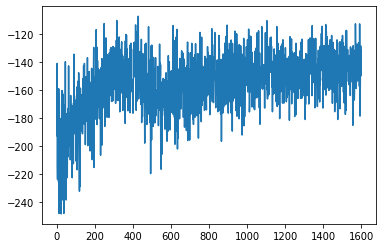

In [ ]:
plt.plot(meanrew)

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2"))

In [ ]:
s1=env1.reset()
s1=torch.FloatTensor(s1).view(1,-1)

In [ ]:
count=0
while count<500:
  env1.render("rgb_array")
  # obs=ptan.agent.float32_preprocessor(obs)
  # action=model.forward(obs)[0].data.cpu().numpy()
  #action=ag.act(s1)[0]
  action=random.choice([0,1,2,3])
  print(action)
  obs,rew,done,_=env1.step(action)
  s1=torch.FloatTensor(obs).view(1,-1)
  count+=1
  if done:
    break

env1.close()

2
0
2
2
2
0
2
1
2
1
3
3
1
2
1
2
0
2
1
2
3
3
3
3
3
3
2
3
2
0
1
2
3
3
2
0
1
3
2
0
0
2
3
3
2
0
3
0
1
1
3
1
1
3
3
3
1
2
3
1
1
2
0
1
2
0
2
3
0
0
2
3
3
3
2
0
0
3
3
1
2
0


In [ ]:
show_video()